Notebook to investigate raw FinBERT predictions (excluding results of Granger Causality & OLS, see \notebooks\exploratory_analysis_regression_results.ipnyb)

In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
import datetime as dt
import sqlite3
from collections import defaultdict

# connect to folder for custom functions
root = Path.cwd().parent
vis_path = root / "src" / "visualizations" 
mod_path = root / "src" / "modelling" 
sys.path.append(str(vis_path))
sys.path.append(str(mod_path))

from read_articles import read, investigate_hype_articles
from plot_functions import plot_aini_means_three_panels, plot_aini_hist_grid_by_years, plot_timeline, plot_n_articles_with_extrema_events
from compute_extrema import compute_aini_extrema
from calculate_summary_statistics import calculate_aini_statistics

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# prepare paths
var_path = root / "data" / "processed" / "variables"
art_path = root / "data" / "processed" / "articles"
table_path = root / "reports" / "tables"
fig_path = root / "reports" / "figures"

# load aini data
aini_custom = pd.read_csv(var_path / "binary_AINI_variables.csv")
aini_w0 = pd.read_csv(var_path / "w0_AINI_variables.csv")
aini_w1 = pd.read_csv(var_path / "w1_AINI_variables.csv")
aini_w2 =  pd.read_csv(var_path / "w2_AINI_variables.csv")
aini_w2

,date,normalized_AINI,simple_AINI,EMA_02,EMA_08
0,2023-04-01,0.0,0,0.000000,0.000000
1,2023-04-02,0.0,0,0.000000,0.000000
2,2023-04-03,0.0,0,0.000000,0.000000
3,2023-04-04,0.0,0,0.000000,0.000000
4,2023-04-05,0.0,0,0.000000,0.000000
...,...,...,...,...,...
776,2025-06-12,0.0,0,0.047604,0.013605
777,2025-06-13,0.1,3,0.058083,0.082721
778,2025-06-14,0.0,0,0.046467,0.016544
779,2025-06-15,0.0,0,0.037173,0.003309


In [3]:
# create dataframes for visualizaions
normalized_AINI = pd.DataFrame()

# ensure sorting
aini_w0 = aini_w0.sort_values("date")
aini_w1 = aini_w1.sort_values("date")
aini_w2 = aini_w2.sort_values("date")
aini_custom = aini_custom.sort_values("date")

# compute extrema; exclude noisy dates & 0 AINI vals
merged, tidy, pivot, extrema = compute_aini_extrema(aini_w0,aini_w1,aini_w2,aini_custom,
                                                    exclude_dates=["2023-07-15","2023-06-30","2023-04-01","2023-04-02"])
merged

c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_nonzero[value_cols] = merged_nonzero[value_cols].apply(pd.to_numeric, errors="coerce")
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:145: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tidy.pivot_table(
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

,date,normalized_AINI_w0,simple_AINI_w0,EMA_02_w0,EMA_08_w0,normalized_AINI_w1,simple_AINI_w1,EMA_02_w1,EMA_08_w1,normalized_AINI_w2,simple_AINI_w2,EMA_02_w2,EMA_08_w2,normalized_AINI_custom,simple_AINI_custom,EMA_02_custom,EMA_08_custom
2,2023-04-03,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
3,2023-04-04,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,2023-04-05,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
5,2023-04-06,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,-0.076923,-1,-0.015385,-0.061538
6,2023-04-07,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,-0.012308,-0.012308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2025-06-12,0.000000,0,0.043486,0.014145,0.000000,0,0.035155,0.010033,0.0,0,0.047604,0.013605,-0.055556,-2,-0.098190,-0.049539
777,2025-06-13,0.033333,1,0.041456,0.029496,0.100000,3,0.048124,0.082007,0.1,3,0.058083,0.082721,-0.166667,-5,-0.111886,-0.143241
778,2025-06-14,0.000000,0,0.033164,0.005899,0.000000,0,0.038499,0.016401,0.0,0,0.046467,0.016544,0.000000,0,-0.089509,-0.028648
779,2025-06-15,0.000000,0,0.026532,0.001180,0.000000,0,0.030799,0.003280,0.0,0,0.037173,0.003309,0.000000,0,-0.071607,-0.005730


In [4]:
# show extrema
extrema.sort_values("n measures",ascending=False)

,type,date,n measures,measure
0,minimum,2025-02-06,3,"normalized_AINI_custom, EMA_02_custom, EMA_08_..."
13,maximum,2025-06-07,3,"normalized_AINI_w0, EMA_02_w0, EMA_08_w0"
14,maximum,2025-06-16,3,"normalized_AINI_w2, EMA_02_w2, EMA_08_w2"
3,minimum,2025-01-28,2,"normalized_AINI_w1, EMA_08_w1"
2,minimum,2024-08-02,2,"normalized_AINI_w2, EMA_08_w2"
1,minimum,2023-08-13,2,"normalized_AINI_w0, EMA_08_w0"
4,minimum,2025-01-31,2,"EMA_02_w1, EMA_02_w2"
15,maximum,2025-06-10,2,"normalized_AINI_w1, EMA_08_w1"
16,maximum,2023-04-09,1,EMA_02_custom
5,minimum,2025-01-20,1,EMA_02_w0


Explore differences in min, max, mean and std. of AINI variables

In [5]:
stats = calculate_aini_statistics(merged)
stats.to_html(table_path / "AINI_summary_statistics.html")
stats

,scope,variable,count,mean,std,min,median,max
0,Total,EMA_02_custom,777,-0.087874,0.031707,-0.284651,-0.086383,0.000000
1,Total,EMA_02_w0,777,-0.000685,0.019074,-0.068745,0.000072,0.058285
2,Total,EMA_02_w1,777,-0.004583,0.023217,-0.109569,-0.002466,0.057163
3,Total,EMA_02_w2,777,-0.005780,0.022230,-0.097269,-0.003288,0.069739
4,Total,EMA_08_custom,777,-0.087730,0.063610,-0.456777,-0.081409,0.000000
...,...,...,...,...,...,...,...,...
59,2025,normalized_AINI_w2,141,0.000121,0.069441,-0.208333,0.000000,0.200000
60,2025,simple_AINI_custom,141,-3.106383,3.600996,-26.000000,-2.000000,0.000000
61,2025,simple_AINI_w0,141,0.141844,1.895791,-5.000000,0.000000,7.000000
62,2025,simple_AINI_w1,141,0.078014,2.324008,-8.000000,0.000000,8.000000


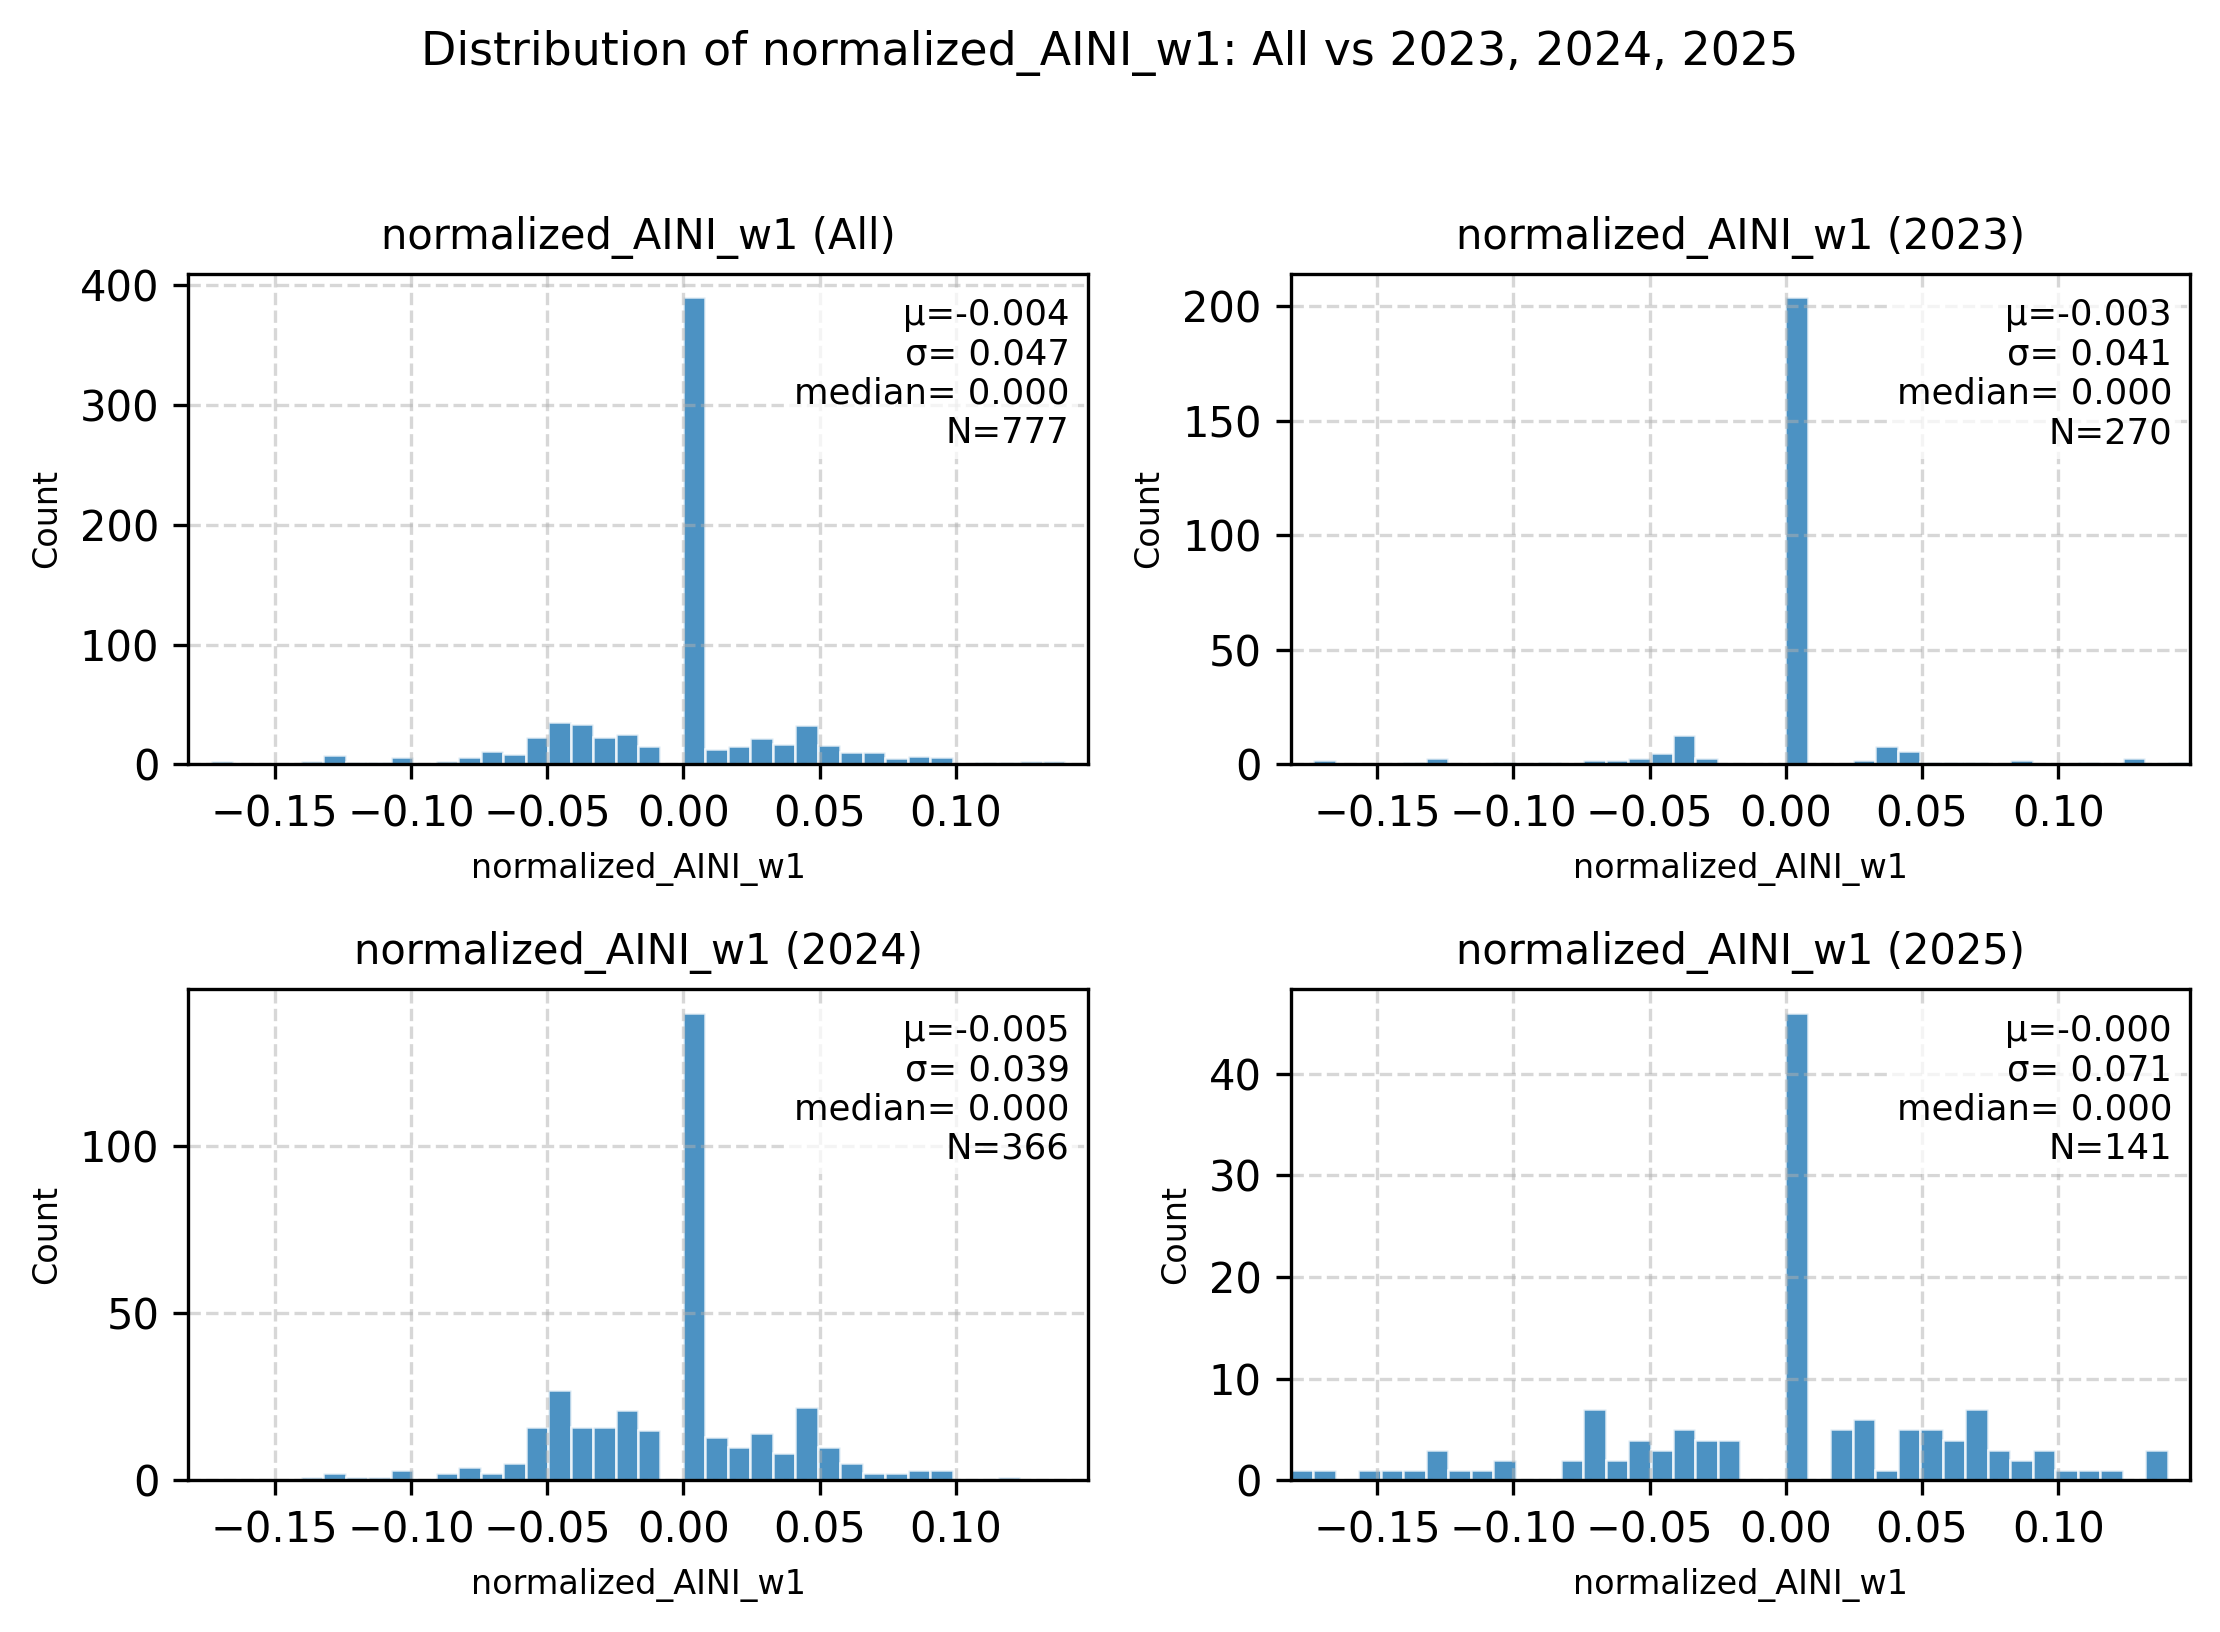

,date,normalized_AINI_w0,simple_AINI_w0,EMA_02_w0,EMA_08_w0,normalized_AINI_w1,simple_AINI_w1,EMA_02_w1,EMA_08_w1,normalized_AINI_w2,simple_AINI_w2,EMA_02_w2,EMA_08_w2,normalized_AINI_custom,simple_AINI_custom,EMA_02_custom,EMA_08_custom
2,2023-04-03,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
3,2023-04-04,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,2023-04-05,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
5,2023-04-06,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,-0.076923,-1,-0.015385,-0.061538
6,2023-04-07,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,-0.012308,-0.012308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2025-06-12,0.000000,0,0.043486,0.014145,0.000000,0,0.035155,0.010033,0.0,0,0.047604,0.013605,-0.055556,-2,-0.098190,-0.049539
777,2025-06-13,0.033333,1,0.041456,0.029496,0.100000,3,0.048124,0.082007,0.1,3,0.058083,0.082721,-0.166667,-5,-0.111886,-0.143241
778,2025-06-14,0.000000,0,0.033164,0.005899,0.000000,0,0.038499,0.016401,0.0,0,0.046467,0.016544,0.000000,0,-0.089509,-0.028648
779,2025-06-15,0.000000,0,0.026532,0.001180,0.000000,0,0.030799,0.003280,0.0,0,0.037173,0.003309,0.000000,0,-0.071607,-0.005730


In [6]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_w1_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            outpath= outpath_hist
        )
merged

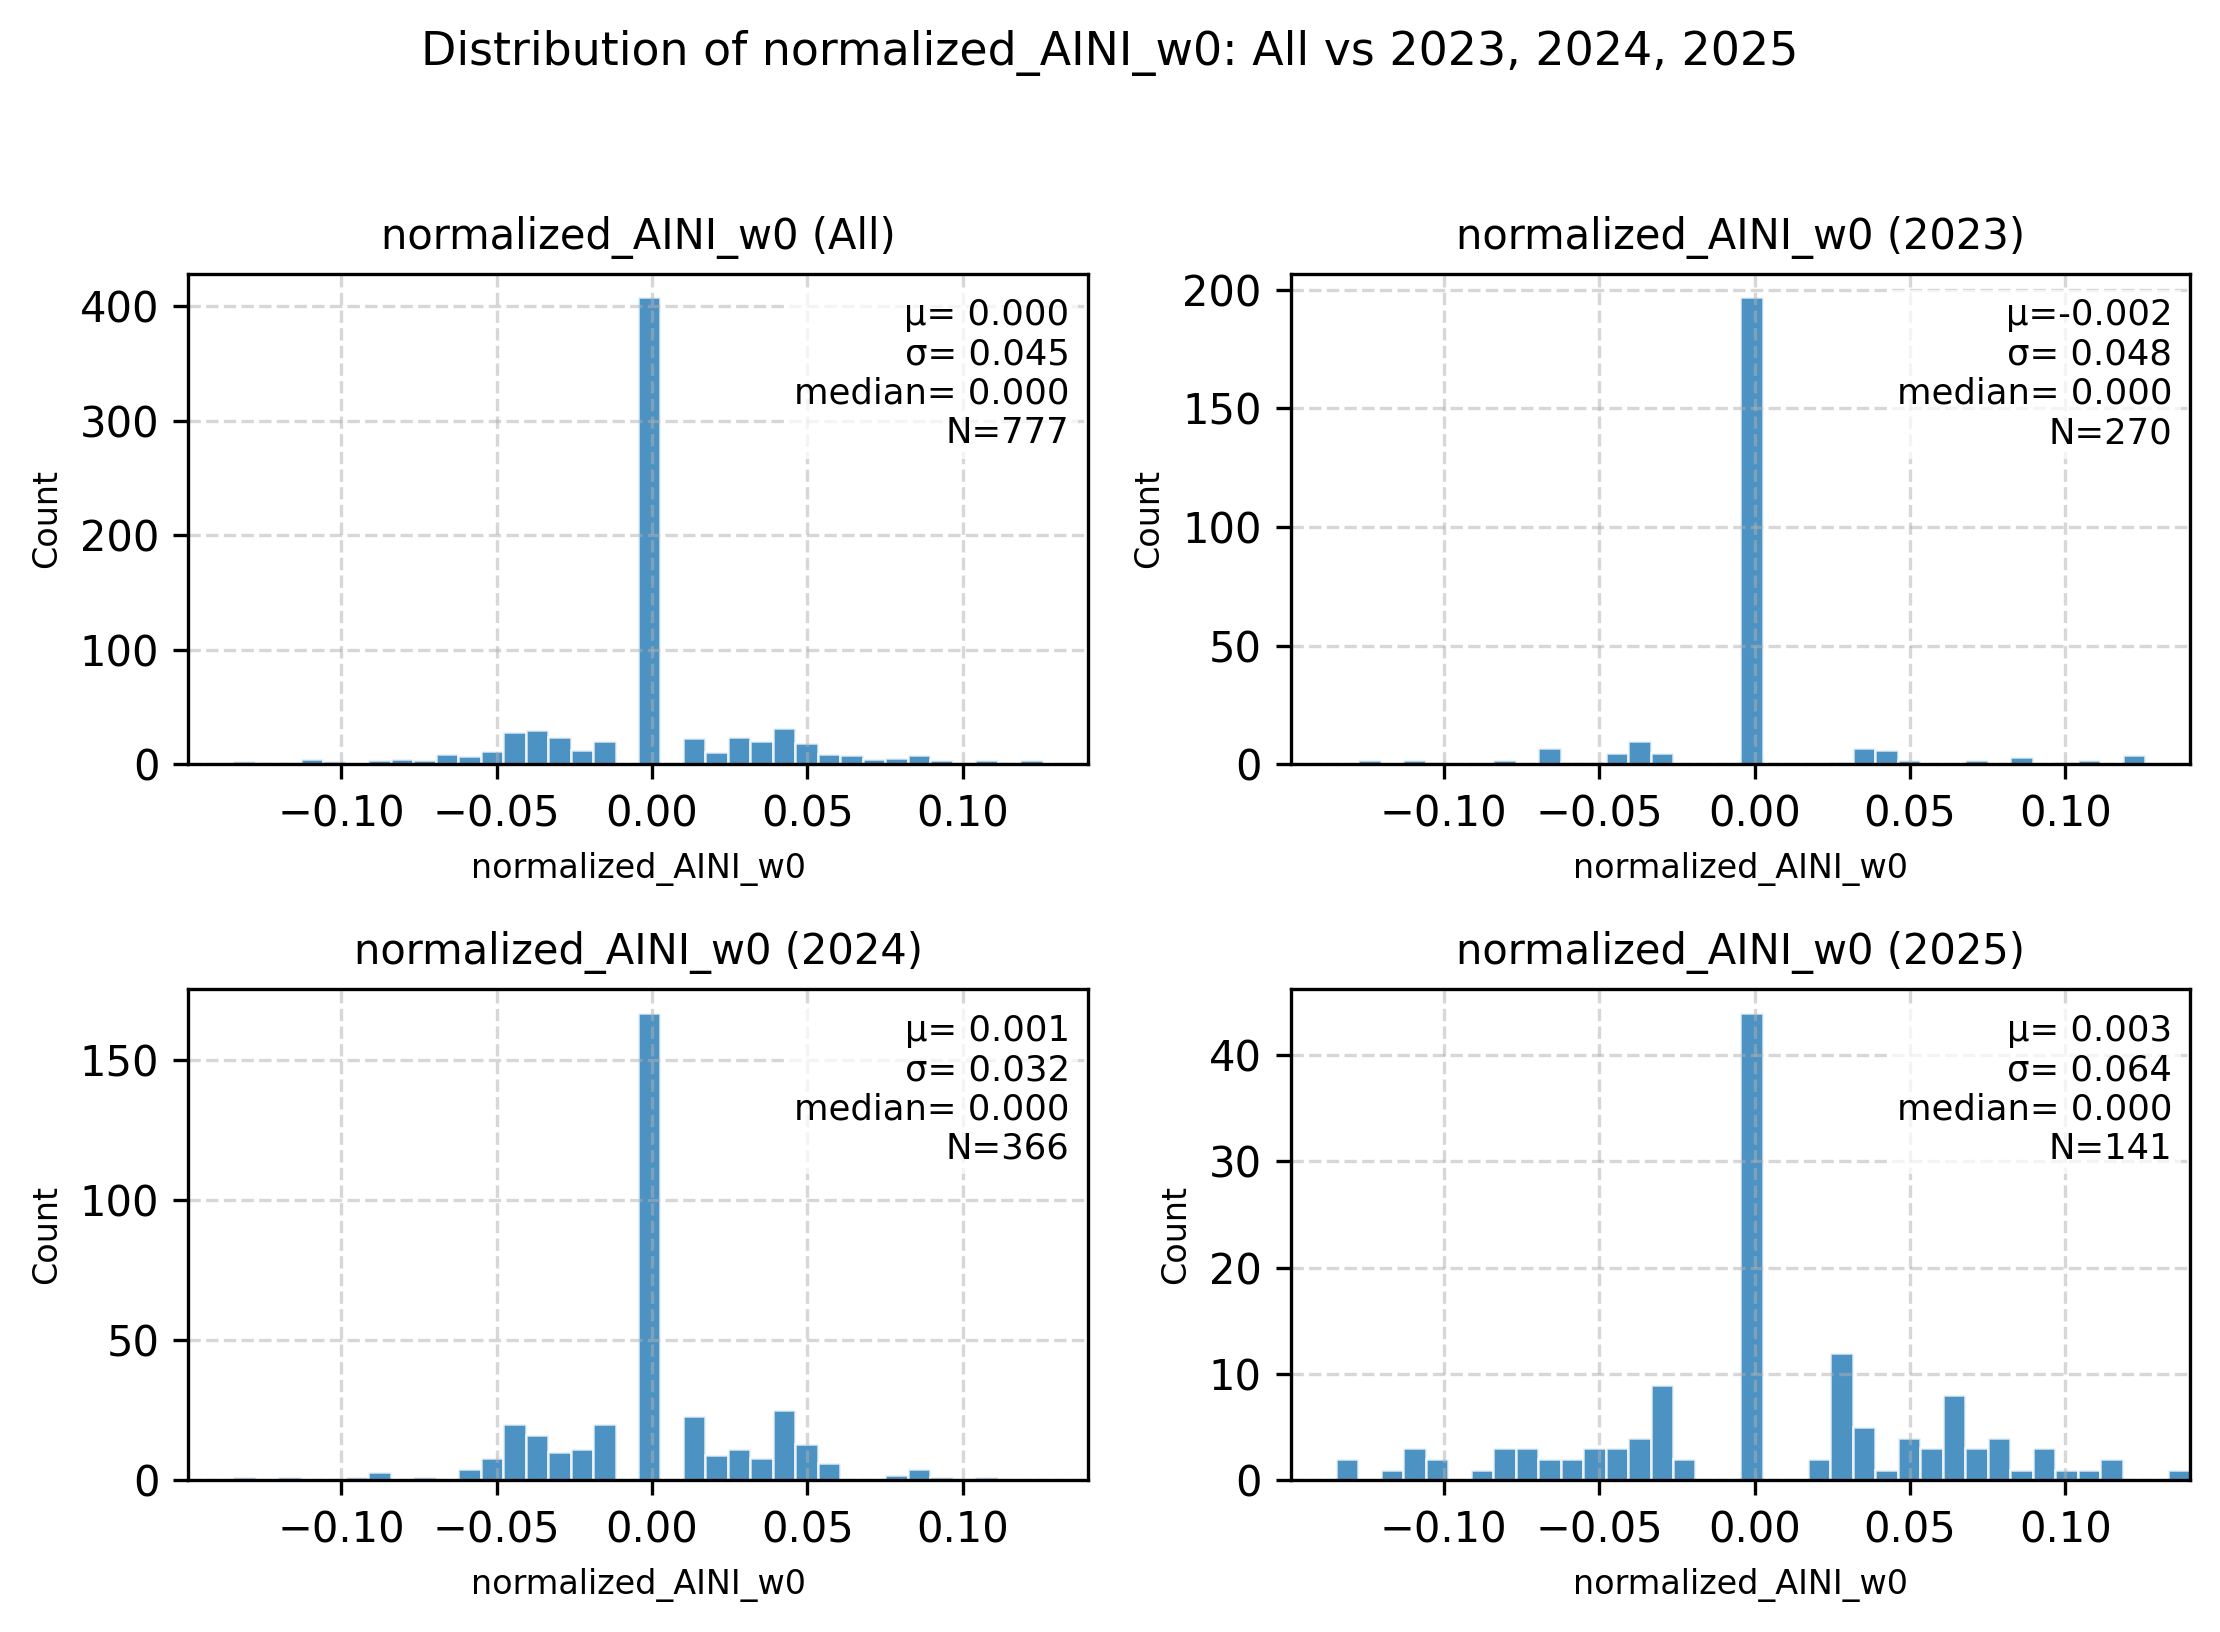

In [7]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_w0_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            measure="normalized_AINI_w0",
            outpath= outpath_hist
        )

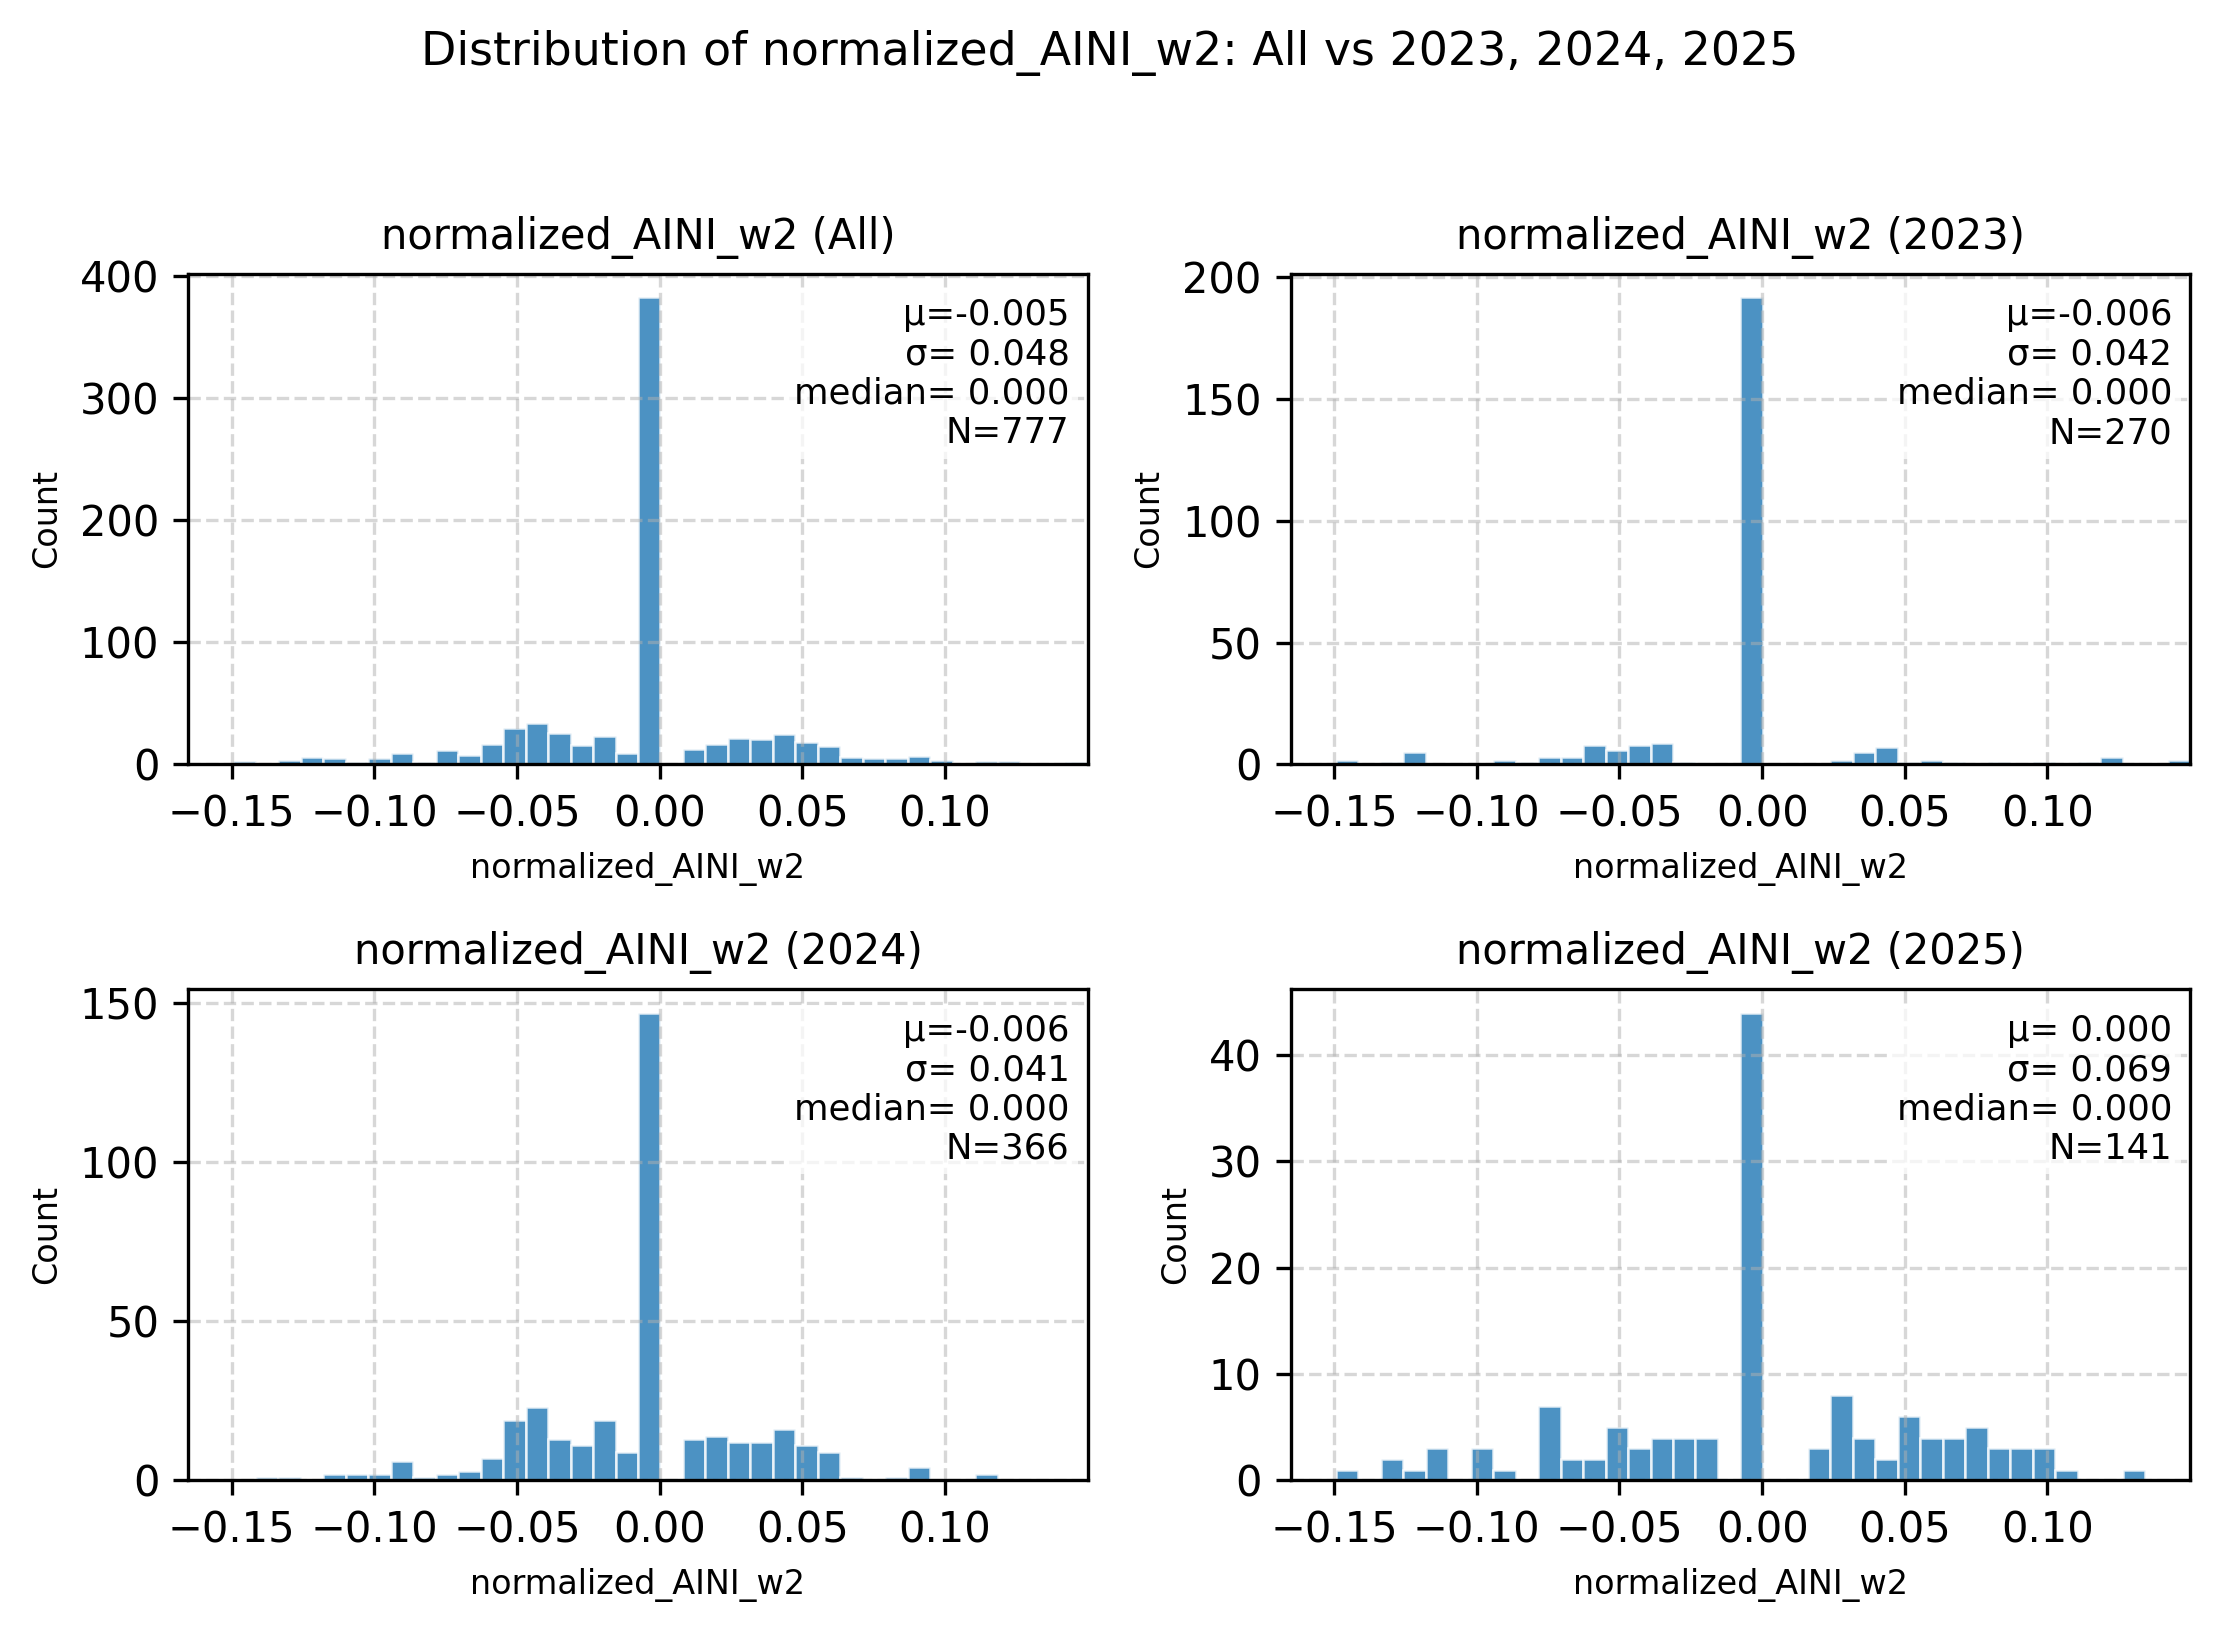

In [8]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_w2_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            measure="normalized_AINI_w2",
            outpath= outpath_hist
        )

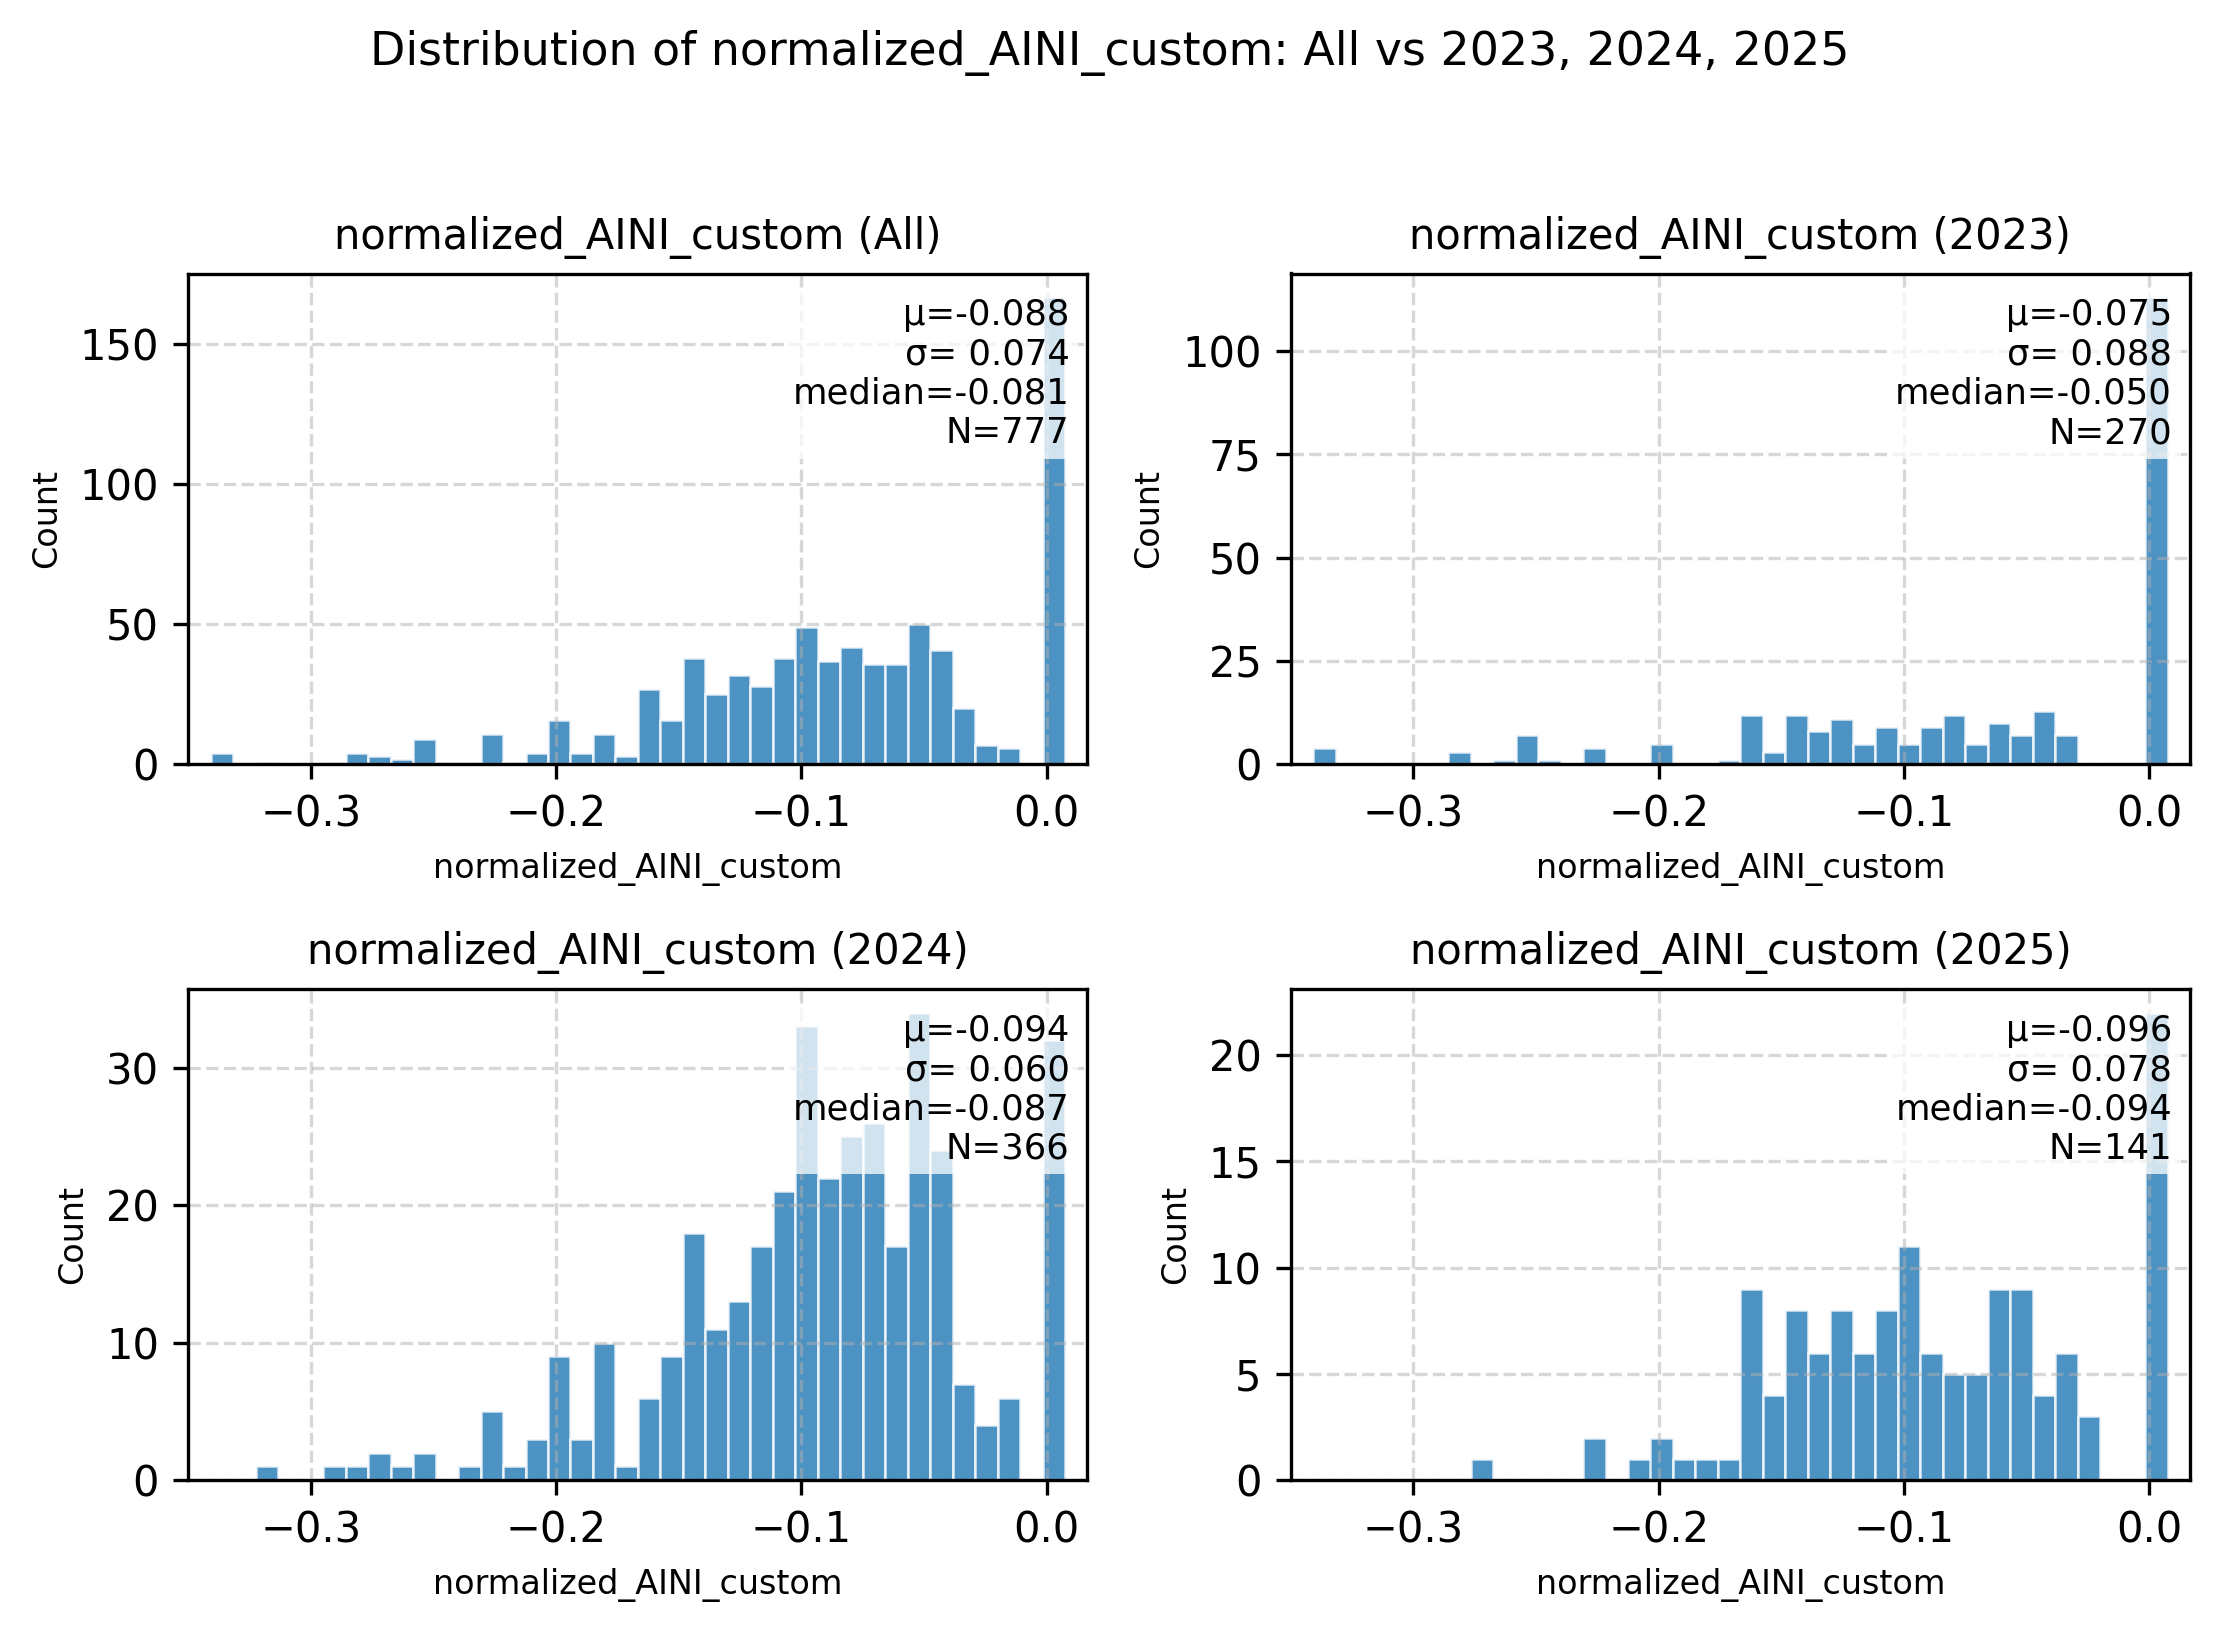

In [8]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_custom_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            measure="normalized_AINI_custom",
            outpath= outpath_hist
        )


In [9]:
# write to csv
extrema.to_csv(table_path / "aini_extrema.csv")

In [10]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

Calculate weekly extrema (by calendar week)

In [11]:
# derive calendar week (ISO year + week number)
tidy["week"] = tidy["date"].dt.to_period("W").apply(lambda r: r.start_time)

# Count how often each min/max week occurs
counts_by_week = (
    tidy.groupby(["type", "week"])
        .size()
        .reset_index(name="count")
        .sort_values(["type", "count"], ascending=[True, False])
)

# subset n > 0
extrema_weekly = counts_by_week[counts_by_week["count"] > 0]

# collect variables for each week
week_dict = (
    tidy.groupby(["week"])["variable"]
    .apply(list)
    .to_dict()
)

# attach variables to each week
extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)

# bring into convenient format
extrema_weekly_clean = extrema_weekly.copy()

# week start (Monday)
week_start = extrema_weekly_clean["week"]
# week end (Sunday) = start + 6 days
week_end = week_start + pd.Timedelta(days=6)

# format as "dd.mm.yyyy - dd.mm.yyyy"
extrema_weekly_clean["week"] = (
    week_start.dt.strftime("%d.%m.%Y") + " - " + week_end.dt.strftime("%d.%m.%Y")
)

extrema_weekly_clean["type"] = extrema_weekly_clean["type"].replace({"min": "minimum", "max": "maximum"})
extrema_weekly_clean.rename(columns={"count": "n measures"}, inplace=True)

# save
extrema_weekly_clean.to_csv(table_path / "aini_weekly_extrema.csv", index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_13008\2630997574.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tidy.groupby(["type", "week"])
C:\Users\PC\AppData\Local\Temp\ipykernel_13008\2630997574.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)
C:\Users\PC\AppData\Local\Temp\ipykernel_13008\2630997574.py:38: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the

In [12]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema_weekly_clean.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema_weekly_clean.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema_weekly.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

In [13]:
extrema_weekly_clean.sort_values("n measures",ascending=False)

,type,week,n measures,measure
6,minimum,27.01.2025 - 02.02.2025,4,"[normalized_AINI_w1, EMA_02_w1, EMA_08_w1, EMA..."
7,minimum,03.02.2025 - 09.02.2025,3,"[normalized_AINI_custom, EMA_02_custom, EMA_08..."
21,maximum,02.06.2025 - 08.06.2025,3,"[normalized_AINI_w0, EMA_02_w0, EMA_08_w0]"
23,maximum,16.06.2025 - 22.06.2025,3,"[normalized_AINI_w2, EMA_02_w2, EMA_08_w2]"
1,minimum,07.08.2023 - 13.08.2023,2,"[normalized_AINI_w0, EMA_08_w0]"
3,minimum,29.07.2024 - 04.08.2024,2,"[normalized_AINI_w2, EMA_08_w2]"
22,maximum,09.06.2025 - 15.06.2025,2,"[normalized_AINI_w1, EMA_08_w1]"
5,minimum,20.01.2025 - 26.01.2025,1,[EMA_02_w0]
12,maximum,03.04.2023 - 09.04.2023,1,[EMA_02_custom]
14,maximum,04.09.2023 - 10.09.2023,1,[EMA_08_custom]


load data with AINI predictions & compare corpora with maxima and minima

In [14]:
# load & merge w1 data custom finbert data
c_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_on_binary.csv")
c_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_on_binary.csv")
c_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_on_binary.csv")
c_df = pd.concat([c_df23,c_df24,c_df25]) 

# load & merge w0 data
w0_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_0.csv")
w0_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_0.csv")
w0_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_0.csv")
w0_df = pd.concat([w0_df23,w0_df24,w0_df25]) 

# load & merge w1 data
w1_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_1.csv")
w1_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_1.csv")
w1_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_1.csv")
w1_df = pd.concat([w1_df23,w1_df24,w1_df25]) 

# merge on normalized_aini_wo to identify relevant articles
w2_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_2.csv")
w2_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_2.csv")
w2_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_2.csv")
w2_df = pd.concat([w2_df23,w2_df24,w2_df25]) 

# create df list 
aini_dfs = [c_df,w0_df,w1_df,w2_df]
print(w0_df[w0_df["article_id"] == 20253960][["corpus","title"]])

                                                 corpus  \
3897  OPINION\nCOMMENTARY\nFollow\nAgency Overreach ...   

                                           title  
3897  Agency Overreach Leaves Patients Untreated  


In [15]:
# verify integrity 
for df in aini_dfs:
    print(
        f"\nFirst entry (date): {df['date'].min()} "
        f"\nLast entry (date): {df['date'].max()} "
        f"\n# entries: {len(df)} "
        f"\n# non-unique article_id: {df['article_id'].duplicated().sum()} "
        f"\n# unique article_id: {df['article_id'].nunique()} " 
        f"\nMin article_id: {df['article_id'].min()} "
        f"\nMax article_id: {df['article_id'].max()} "
        f"\nColumns: {list(df.columns)}\n"
    )



First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 21886 
# non-unique article_id: 0 
# unique article_id: 21886 
Min article_id: 20251 
Max article_id: 202437460 
Columns: ['article_id', 'image_src', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus', 'ai_window', 'predicted_label', 'predicted_class', 'ai_relevant', 'sentiment_label', 'sentiment_score', 'hype_score']


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
# unique article_id: 22904 
Min article_id: 20251 
Max article_id: 202437460 
Columns: ['article_id', 'image_src', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus', 'text', 'ai_window', 'ai_relevant', 'sentiment_label', 'sentiment_score', 'hype_score']


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
# unique a

In [16]:
# investigate duplicates in article ids
dups = w0_df[w0_df[["article_id", "title"]].duplicated(keep=False)].sort_values("article_id")
dups

,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,section,cleaned_corpus,text,ai_window,ai_relevant,sentiment_label,sentiment_score,hype_score


In [17]:
# subset for relevant columns
rel_col = ["date","article_id","sentiment_label","hype_score","ai_window"]
clean_df = []

for df in aini_dfs:
    df = df[rel_col].copy()
    clean_df.append(df)
    
# unpack supsetted dataframes containing Finbert AINI estimates    
c_df_sub,w0_df_sub,w1_df_sub,w2_df_sub = clean_df
w2_df_sub

,date,article_id,sentiment_label,hype_score,ai_window
0,2023-01-10,202336,neutral,0,NaN
1,2023-01-10,202339,neutral,0,NaN
2,2023-01-12,202387,neutral,0,NaN
3,2023-01-12,2023102,neutral,0,NaN
4,2023-01-13,2023111,neutral,0,NaN
...,...,...,...,...,...
4055,2025-06-16,20254120,neutral,0,NaN
4056,2025-06-16,20254121,neutral,0,NaN
4057,2025-06-16,20254122,neutral,0,NaN
4058,2025-06-16,20254123,neutral,0,NaN


In [18]:
# verify integrity 
for df in clean_df:
    print(
        f"First entry (date): {df['date'].min()} "
        f"\nLast entry (date): {df['date'].max()} "
        f"\n# entries: {len(df)} "
        f"\n# non-unique article_id: {df['article_id'].duplicated().sum()} "
        f"\nColumns: {list(df.columns)}\n"
    )


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 21886 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']



Combine AINI predictions to investigate minima & maxima

In [19]:
# harmonize ids
w0 = w0_df_sub.copy()
w1 = w1_df_sub.copy()
w2 = w2_df_sub.copy()
c  = c_df_sub.copy()

# bring to datetime, normalize to 00:00:00
for df in (w0, w1, w2, c):
    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()

# left join
complete_left = w0.copy()
complete_left = complete_left.merge(
    w1, on="article_id", how="left", suffixes=("", "_w1"), validate="one_to_one"
)
complete_left = complete_left.merge(
    w2, on="article_id", how="left", suffixes=("", "_w2"), validate="one_to_one"
)
complete_left = complete_left.merge(
    c,  on="article_id", how="left", suffixes=("", "_c"),  validate="one_to_one"
)

# control: outer join
complete_outer = w0.merge(
    w1, on="article_id", how="outer", suffixes=("", "_w1"), validate="one_to_one"
)
complete_outer = complete_outer.merge(
    w2, on="article_id", how="outer", suffixes=("", "_w2"), validate="one_to_one"
)
complete_outer = complete_outer.merge(
    c,  on="article_id", how="outer", suffixes=("", "_c"),  validate="one_to_one"
)


# compare joins
print("[LEFT] n observations:", len(complete_left))
print("[OUTER] n observations:", len(complete_outer))
complete_left

[LEFT] n observations: 22904
[OUTER] n observations: 22904


,date,article_id,sentiment_label,hype_score,ai_window,date_w1,sentiment_label_w1,hype_score_w1,ai_window_w1,date_w2,sentiment_label_w2,hype_score_w2,ai_window_w2,date_c,sentiment_label_c,hype_score_c,ai_window_c
0,2023-01-10,202336,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
1,2023-01-10,202339,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
2,2023-01-12,202387,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
3,2023-01-12,2023102,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
4,2023-01-13,2023111,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22899,2025-06-16,20254120,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22900,2025-06-16,20254121,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22901,2025-06-16,20254122,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22902,2025-06-16,20254123,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN


In [20]:
# columns to bring over from w1_df
keep = ["article_id", "title", "sub_title","section", "cleaned_corpus", "date","ai_window"]

# subset + clean IDs on the right side
for_texts = w1_df.loc[:, keep].copy()
for_texts["article_id"] = (
    for_texts["article_id"]
    .astype(str)
    .str.replace(r"[\u200b\u200c\u200d\ufeff]", "", regex=True)  # zero-width + BOM
    .str.strip()
)

# ensure right side has unique keys 
for_texts = for_texts.drop_duplicates(subset="article_id", keep="first")

# clean IDs on the left
complete_left = complete_left.copy()
complete_left["article_id"] = (
    complete_left["article_id"]
    .astype(str)
    .str.replace(r"[\u200b\u200c\u200d\ufeff]", "", regex=True)
    .str.strip()
)

# go for left join (validated by inner)
complete_df = complete_left.copy()

# rename for consistency
complete_df = complete_df.rename(columns={"hype_score": "hype_score_w0"})
complete_df

,date,article_id,sentiment_label,hype_score_w0,ai_window,date_w1,sentiment_label_w1,hype_score_w1,ai_window_w1,date_w2,sentiment_label_w2,hype_score_w2,ai_window_w2,date_c,sentiment_label_c,hype_score_c,ai_window_c
0,2023-01-10,202336,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
1,2023-01-10,202339,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
2,2023-01-12,202387,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
3,2023-01-12,2023102,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
4,2023-01-13,2023111,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22899,2025-06-16,20254120,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22900,2025-06-16,20254121,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22901,2025-06-16,20254122,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22902,2025-06-16,20254123,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN


C:\Users\PC\AppData\Local\Temp\ipykernel_13008\2337388238.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["hype_score_mean"] = complete_df[hype_cols].mean(axis=1)
C:\Users\PC\AppData\Local\Temp\ipykernel_13008\2337388238.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")


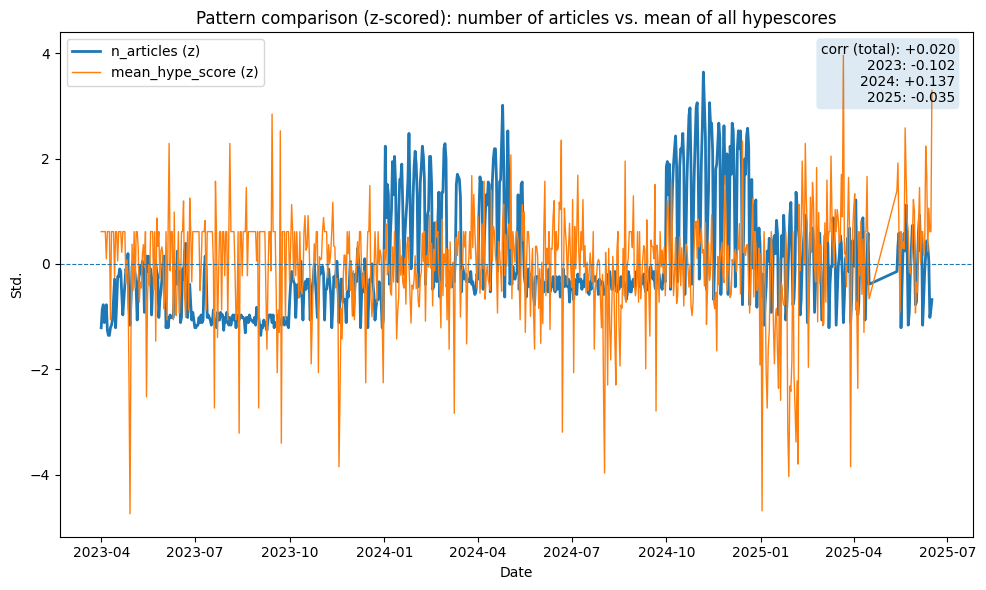

In [21]:
# define noisy dates 
exclude_dates=["2023-07-15","2023-06-30"]

# subset to exclude noise
complete_df = complete_df[~complete_df["date"].isin(pd.to_datetime(exclude_dates))]

# define relevant columns
hype_cols = ["hype_score_w0", "hype_score_w1", "hype_score_w2", "hype_score_c"]

# compute row-wise mean across all hype scores (per article)
complete_df["hype_score_mean"] = complete_df[hype_cols].mean(axis=1)

# aggregate to date level: count articles and mean of the row-wise mean
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")
complete_agg = (
    complete_df.groupby("date", as_index=False)
    .agg(
        n_articles=("article_id", "count"),
        mean_hype_score=("hype_score_mean", "mean")
    )
)

# subset to exclude data prior 01.04.2023
cutoff = dt.datetime(2023, 4, 1)
complete_agg = complete_agg[complete_agg["date"] >= cutoff]

# prepare dataframe for plotting
dfp = complete_agg.set_index("date").copy()

# z-score helper that avoids div-by-zero
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std()
    if pd.isna(sd) or sd == 0:
        return s * 0  # all zeros if no variation
    return (s - mu) / sd

# z-score series
dfp["n_articles_z"] = zscore(dfp["n_articles"])
dfp["mean_hype_score_z"] = zscore(dfp["mean_hype_score"])

# total corr
r_total = float(dfp["n_articles_z"].corr(dfp["mean_hype_score_z"]))

# yearly corrs
yearly_corrs = {}
for y, g in dfp.groupby(dfp.index.year):
    if len(g) >= 2:
        yearly_corrs[int(y)] = float(g["n_articles_z"].corr(g["mean_hype_score_z"]))
    else:
        yearly_corrs[int(y)] = np.nan

# build annotation text
lines = [f"corr (total): {r_total:+.3f}"]
for y in sorted(yearly_corrs):
    r = yearly_corrs[y]
    lines.append(f"{y}: {r:+.3f}" if np.isfinite(r) else f"{y}: n/a")
anno_text = "\n".join(lines)

# plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dfp.index, dfp["n_articles_z"], linewidth=2, label="n_articles (z)")
ax.plot(dfp.index, dfp["mean_hype_score_z"], linewidth=1, label="mean_hype_score (z)")

ax.axhline(0, linestyle="--", linewidth=0.8)
ax.set_title("Pattern comparison (z-scored): number of articles vs. mean of all hypescores")
ax.set_xlabel("Date")
ax.set_ylabel("Std.")
ax.legend(loc="upper left", ncol=1)

# annotation box (upper right inside axes)
ax.text(
    0.98, 0.98, anno_text,
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.15, edgecolor="none")
)

fig.tight_layout()
plt.show()

Investigate yearly correlation between raw hype scores & number of articles

In [22]:
# define hype cols present
hcols_present = [c for c in hype_cols if c in complete_df.columns]

# aggregate to date level: counts + daily means for each hype variant
complete_agg = (
    complete_df.groupby("date", as_index=False)
    .agg(
        n_articles=("article_id", "count"),
        **{f"{c}_mean": (c, "mean") for c in hcols_present},
        mean_hype_score=("hype_score_mean", "mean")  
    )
)

# build dfp
dfp = complete_agg.set_index("date").copy()

# z-score
dfp["n_articles_z"] = zscore(dfp["n_articles"])
for c in hcols_present:
    dfp[f"{c}_mean_z"] = zscore(dfp[f"{c}_mean"])

# total correlations
total_corrs = {c: float(dfp["n_articles_z"].corr(dfp[f"{c}_mean_z"])) for c in hcols_present}

# yearly correlations
corr_by_year = (
    dfp.assign(year=dfp.index.year)
       .groupby("year")
       .apply(lambda g: pd.Series({
           c: float(g["n_articles_z"].corr(g[f"{c}_mean_z"])) if len(g) >= 2 else np.nan
           for c in hcols_present
       }))
       .sort_index()
)

# append total row
corr_by_year.loc["total"] = pd.Series(total_corrs)

print(corr_by_year.round(3)) 

# subset for reporting
n_articles_df = complete_agg.loc[:, ["date", "n_articles"]].copy()

# save as scv
n_articles_df.to_csv(var_path / "n_articles.csv")

       hype_score_w0  hype_score_w1  hype_score_w2  hype_score_c
year                                                            
2023          -0.000         -0.004         -0.037         0.034
2024           0.032          0.087          0.120         0.112
2025           0.059          0.090          0.111        -0.330
total          0.045          0.044          0.067        -0.021


C:\Users\PC\AppData\Local\Temp\ipykernel_13008\3522836586.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Compute correlation between n articles & processed AINI values

In [23]:
MEASURE_COLS = [
    "normalized_AINI_w0", "EMA_02_w0", "EMA_08_w0",
    "normalized_AINI_w1",  "EMA_02_w1", "EMA_08_w1",
    "normalized_AINI_w2", "EMA_02_w2", "EMA_08_w2",
    "normalized_AINI_custom", "EMA_02_custom", "EMA_08_custom",
]

merged_df = merged.copy()
merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")
merged_df = merged_df.dropna(subset=["date"])
present_measures = [c for c in MEASURE_COLS if c in merged_df.columns]

n_base = complete_agg[["date", "n_articles"]].copy()

# join measures with n_articles on date 
m = (
    merged_df[["date"] + present_measures]
    .merge(n_base, on="date", how="inner")
    .sort_values("date")
)

# verify integrity
print(f"Number of measures {m.shape[0]}",
      f"\n First datapoint: {min(m.date)}",
      f"\n Last datapoint: {max(m.date)}",
      f"\n Duplicates: {m['date'].duplicated().sum()}")

Number of measures 777 
 First datapoint: 2023-04-03 00:00:00 
 Last datapoint: 2025-06-16 00:00:00 
 Duplicates: 0


In [24]:
# helper for correlations
def _corr_block(g: pd.DataFrame, measures) -> pd.Series:
    out = {}
    for c in measures:
        if g[c].notna().sum() >= 2 and g["n_articles"].notna().sum() >= 2:
            out[c] = float(g["n_articles"].corr(g[c]))
        else:
            out[c] = np.nan
    return pd.Series(out)

# add year column
m["year"] = m["date"].dt.year

# compute by year
corr_by_year = m.groupby("year", dropna=True).apply(lambda g: _corr_block(g, present_measures))

# add total row
corr_by_year.loc["total"] = _corr_block(m, present_measures)

# pretty output
corr_by_year_rounded = corr_by_year.round(3)
print(corr_by_year_rounded)

       normalized_AINI_w0  EMA_02_w0  EMA_08_w0  normalized_AINI_w1  \
year                                                                  
2023               -0.039     -0.090     -0.045              -0.053   
2024                0.032      0.039      0.035               0.087   
2025                0.059     -0.022      0.063               0.090   
total               0.029      0.048      0.036               0.032   

       EMA_02_w1  EMA_08_w1  normalized_AINI_w2  EMA_02_w2  EMA_08_w2  \
year                                                                    
2023      -0.058     -0.046              -0.124     -0.114     -0.126   
2024       0.162      0.100               0.120      0.212      0.137   
2025      -0.044      0.076               0.111     -0.019      0.108   
total      0.035      0.036               0.058      0.082      0.066   

       normalized_AINI_custom  EMA_02_custom  EMA_08_custom  
year                                                         
2023      

C:\Users\PC\AppData\Local\Temp\ipykernel_13008\3378966710.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_by_year = m.groupby("year", dropna=True).apply(lambda g: _corr_block(g, present_measures))


Calculate means  & rations of means against each other

In [25]:
# define columns for aggregation
w0_col = ["normalized_AINI_w0","EMA_02_w0","EMA_08_w0"]
w1_col = ["normalized_AINI_w1","EMA_02_w1","EMA_08_w1"]
w2_col = ["normalized_AINI_w2","EMA_02_w2","EMA_08_w2"]
c_col = ["normalized_AINI_custom","EMA_02_custom","EMA_08_custom"]

# calculate means
m["w0_mean"] = m[w0_col].mean(axis=1)
m["w1_mean"] = m[w1_col].mean(axis=1)
m["w2_mean"] = m[w2_col].mean(axis=1)
m["c_mean"]  = m[c_col].mean(axis=1)

# calc fractions
group_cols = ["w0_mean", "w1_mean", "w2_mean", "c_mean"]


yearly_means = (
    m.groupby(m["date"].dt.year)[group_cols]
     .mean()
)

# "total" over all years
total_means = m[group_cols].mean().to_frame().T
total_means.index = ["total"]

means = pd.concat([yearly_means, total_means])

# compute pairwise ratios
fractions = {}

for a in group_cols:
    for b in group_cols:
        if a != b:
            fractions[f"{a}/{b}"] = means[a] / means[b]

frac_df = pd.DataFrame(fractions)


print(yearly_means)
print(frac_df.round(3))
m

       w0_mean   w1_mean   w2_mean    c_mean
date                                        
2023 -0.002752 -0.003545 -0.006710 -0.074837
2024  0.000514 -0.005405 -0.005585 -0.093813
2025  0.002678 -0.001047 -0.000807 -0.096626
       w0_mean/w1_mean  w0_mean/w2_mean  w0_mean/c_mean  w1_mean/w0_mean  \
2023             0.776            0.410           0.037            1.288   
2024            -0.095           -0.092          -0.005          -10.517   
2025            -2.559           -3.319          -0.028           -0.391   
total            0.058            0.045           0.003           17.381   

       w1_mean/w2_mean  w1_mean/c_mean  w2_mean/w0_mean  w2_mean/w1_mean  \
2023             0.528           0.047            2.438            1.892   
2024             0.968           0.058          -10.869            1.033   
2025             1.297           0.011           -0.301            0.771   
total            0.777           0.045           22.379            1.288   

       w2_mea

,date,normalized_AINI_w0,EMA_02_w0,EMA_08_w0,normalized_AINI_w1,EMA_02_w1,EMA_08_w1,normalized_AINI_w2,EMA_02_w2,EMA_08_w2,normalized_AINI_custom,EMA_02_custom,EMA_08_custom,n_articles,year,w0_mean,w1_mean,w2_mean,c_mean
0,2023-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,13,2023,0.000000,0.000000,0.000000,0.000000
1,2023-04-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6,2023,0.000000,0.000000,0.000000,0.000000
2,2023-04-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,10,2023,0.000000,0.000000,0.000000,0.000000
3,2023-04-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.076923,-0.015385,-0.061538,13,2023,0.000000,0.000000,0.000000,-0.051282
4,2023-04-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.012308,-0.012308,3,2023,0.000000,0.000000,0.000000,-0.008205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2025-06-12,0.000000,0.043486,0.014145,0.000000,0.035155,0.010033,0.0,0.047604,0.013605,-0.055556,-0.098190,-0.049539,36,2025,0.019210,0.015062,0.020403,-0.067762
773,2025-06-13,0.033333,0.041456,0.029496,0.100000,0.048124,0.082007,0.1,0.058083,0.082721,-0.166667,-0.111886,-0.143241,30,2025,0.034762,0.076710,0.080268,-0.140598
774,2025-06-14,0.000000,0.033164,0.005899,0.000000,0.038499,0.016401,0.0,0.046467,0.016544,0.000000,-0.089509,-0.028648,8,2025,0.013021,0.018300,0.021004,-0.039386
775,2025-06-15,0.000000,0.026532,0.001180,0.000000,0.030799,0.003280,0.0,0.037173,0.003309,0.000000,-0.071607,-0.005730,11,2025,0.009237,0.011360,0.013494,-0.025779


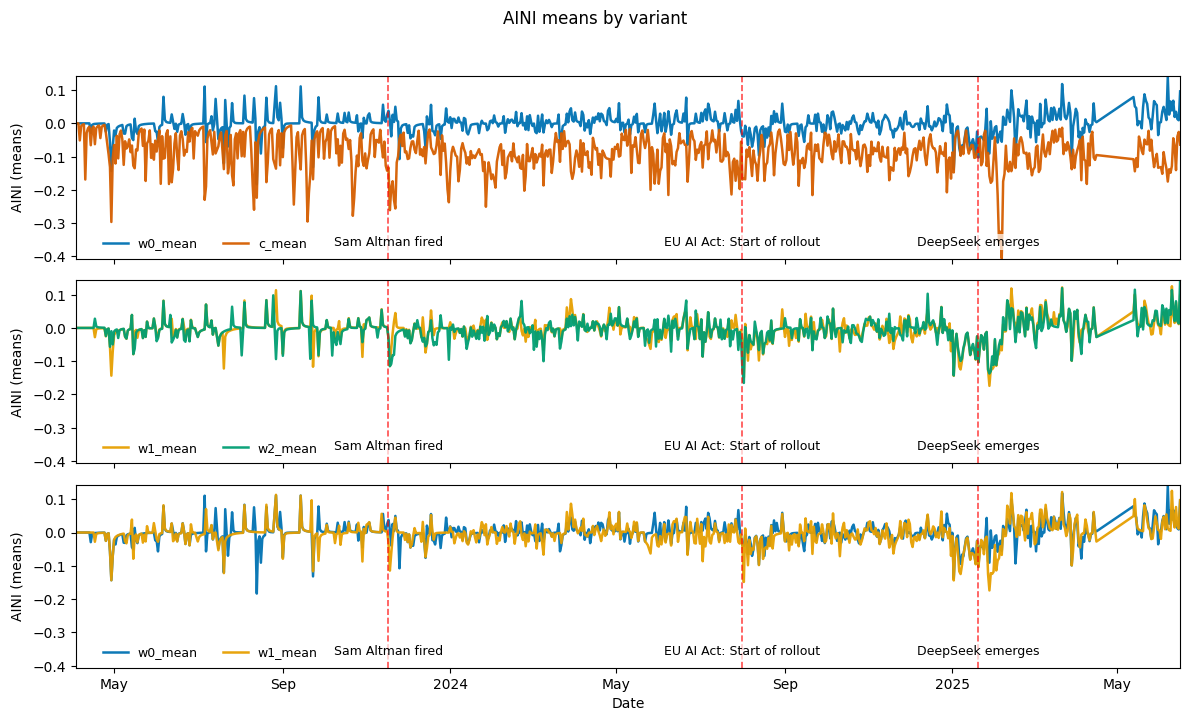

In [26]:
plot_path = fig_path / "aini_means.png"
plot_aini_means_three_panels(m,
                            title = "AINI means by variant",
                            outpath = plot_path )

Investigate extrema manually

In [27]:
# exclude 0 values [created due to symmetrie]
extrema = extrema[extrema["n measures"] > 0]

# again display extrema to define minima & maxima
extrema.sort_values(["type","n measures"],ascending=(False,False))

,type,date,n measures,measure
13,maximum,2025-06-07,3,"normalized_AINI_w0, EMA_02_w0, EMA_08_w0"
14,maximum,2025-06-16,3,"normalized_AINI_w2, EMA_02_w2, EMA_08_w2"
15,maximum,2025-06-10,2,"normalized_AINI_w1, EMA_08_w1"
16,maximum,2023-04-09,1,EMA_02_custom
17,maximum,2023-09-07,1,EMA_08_custom
18,maximum,2024-10-10,1,normalized_AINI_custom
19,maximum,2025-03-22,1,EMA_02_w1
0,minimum,2025-02-06,3,"normalized_AINI_custom, EMA_02_custom, EMA_08_..."
1,minimum,2023-08-13,2,"normalized_AINI_w0, EMA_08_w0"
2,minimum,2024-08-02,2,"normalized_AINI_w2, EMA_08_w2"


In [28]:

# cutoffs for minima 
min_1_custom  = pd.Timestamp("2025-02-06")  # n = 3 normalized_AINI_custom, EMA_02_custom, EMA_08_custom
min_2_w0      = pd.Timestamp("2023-08-13")  # n = 2 normalized_AINI_w0, EMA_08_w0
min_2_w1      = pd.Timestamp("2025-01-28")  # n = 2 normalized_AINI_w1, EMA_08_w1
min_2_w2      = pd.Timestamp("2024-08-02")  # n = 2 normalized_AINI_w2, EMA_08_w2
min_2_w1_w2   = pd.Timestamp("2025-01-31")  # n = 2 EMA_02_w1, EMA_02_w2 => only mixed!
min_3_w0_02   = pd.Timestamp("2025-01-20")  # n = 1 EMA_02_w0

# cutoffs for maxima, n = 3  
max_1_w0 = pd.Timestamp("2025-06-07")  # n = 3 normalized_AINI_w0, EMA_02_w0, EMA_08_w0
max_1_w2 = pd.Timestamp("2025-06-16")  # n = 3 normalized_AINI_w2, EMA_02_w2, EMA_08_w2

# cutoffs for maxima, n = 2  
max_2_w1 = pd.Timestamp("2025-06-10")  # n = 2 normalized_AINI_w1, EMA_08_w1            

# cutoffs for maxima, n = 1 
max_3_c_norm = pd.Timestamp("2024-10-10")  # n = 1 normalized_AINI_custom
max_3_c_02   = pd.Timestamp("2023-04-09")  # n = 1 EMA_02_custom
max_3_c_08   = pd.Timestamp("2023-09-07")  # n = 1 EMA_08_custom
max_3_w1_02  = pd.Timestamp("2025-03-22")  # n = 1 EMA_02_w1

# define cutoffs in a dict: name -> timestamp (single definition)
cutoffs = {
    # maxima, n=3
    "art_max_1_w0": max_1_w0,
    "art_max_1_w2": max_1_w2,
    # maxima, n=2
    "art_max_2_w1": max_2_w1,
    # maxima, n=1
    "art_max_3_c_norm": max_3_c_norm,
    "art_max_3_c_02":   max_3_c_02,
    "art_max_3_c_08":   max_3_c_08,
    "art_max_3_w1_02":  max_3_w1_02,
    # minima, n=3
    "art_min_1_custom": min_1_custom,
    # minima, n=2
    "art_min_2_w0":    min_2_w0,
    "art_min_2_w1":    min_2_w1,
    "art_min_2_w2":    min_2_w2,
    "art_min_2_w1_w2": min_2_w1_w2,
    # minima, n=1
    "art_min_3_w0_02": min_3_w0_02,
}

# ensure datetime
complete_df = complete_df.copy()
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")

# subset original dataframe by each cutoff date
subsets = {
    name: complete_df.loc[complete_df["date"] == ts].copy()
    for name, ts in cutoffs.items()
}

# helper to count NA-rows for sanity check
def count_nonzero_rows(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    arr = df[cols].fillna(0).to_numpy() if cols else np.empty((len(df), 0))
    return int((arr != 0).any(axis=1).sum()) if arr.size else 0

# check n of observations for all cutoffs (per subset)
for name, df in subsets.items():
    hype_cols = [c for c in ["hype_score_w0","hype_score_w1","hype_score_w2","hype_score_custom","hype_score_c"] if c in df.columns]
    n_nonzero = count_nonzero_rows(df, cols=hype_cols or None)
    print(f"{name}: Total: {len(df)} non-0: {n_nonzero}")

subsets

art_max_1_w0: Total: 5 non-0: 1
art_max_1_w2: Total: 15 non-0: 3
art_max_2_w1: Total: 33 non-0: 9
art_max_3_c_norm: Total: 79 non-0: 6
art_max_3_c_02: Total: 1 non-0: 0
art_max_3_c_08: Total: 5 non-0: 0
art_max_3_w1_02: Total: 6 non-0: 1
art_min_1_custom: Total: 44 non-0: 24
art_min_2_w0: Total: 7 non-0: 2
art_min_2_w1: Total: 36 non-0: 11
art_min_2_w2: Total: 19 non-0: 5
art_min_2_w1_w2: Total: 33 non-0: 5
art_min_3_w0_02: Total: 23 non-0: 5


{'art_max_1_w0':             date article_id sentiment_label  hype_score_w0  \
 22687 2025-06-07   20253906         neutral              0   
 22688 2025-06-07   20253907        positive              1   
 22689 2025-06-07   20253908         neutral              0   
 22690 2025-06-07   20253909         neutral              0   
 22691 2025-06-07   20253910         neutral              0   
 
                                                ai_window    date_w1  \
 22687                                                NaN 2025-06-07   
 22688  ai and crypto czar, has been privately encoura... 2025-06-07   
 22689                                                NaN 2025-06-07   
 22690                                                NaN 2025-06-07   
 22691                                                NaN 2025-06-07   
 
       sentiment_label_w1  hype_score_w1  \
 22687            neutral              0   
 22688            neutral              0   
 22689            neutral             

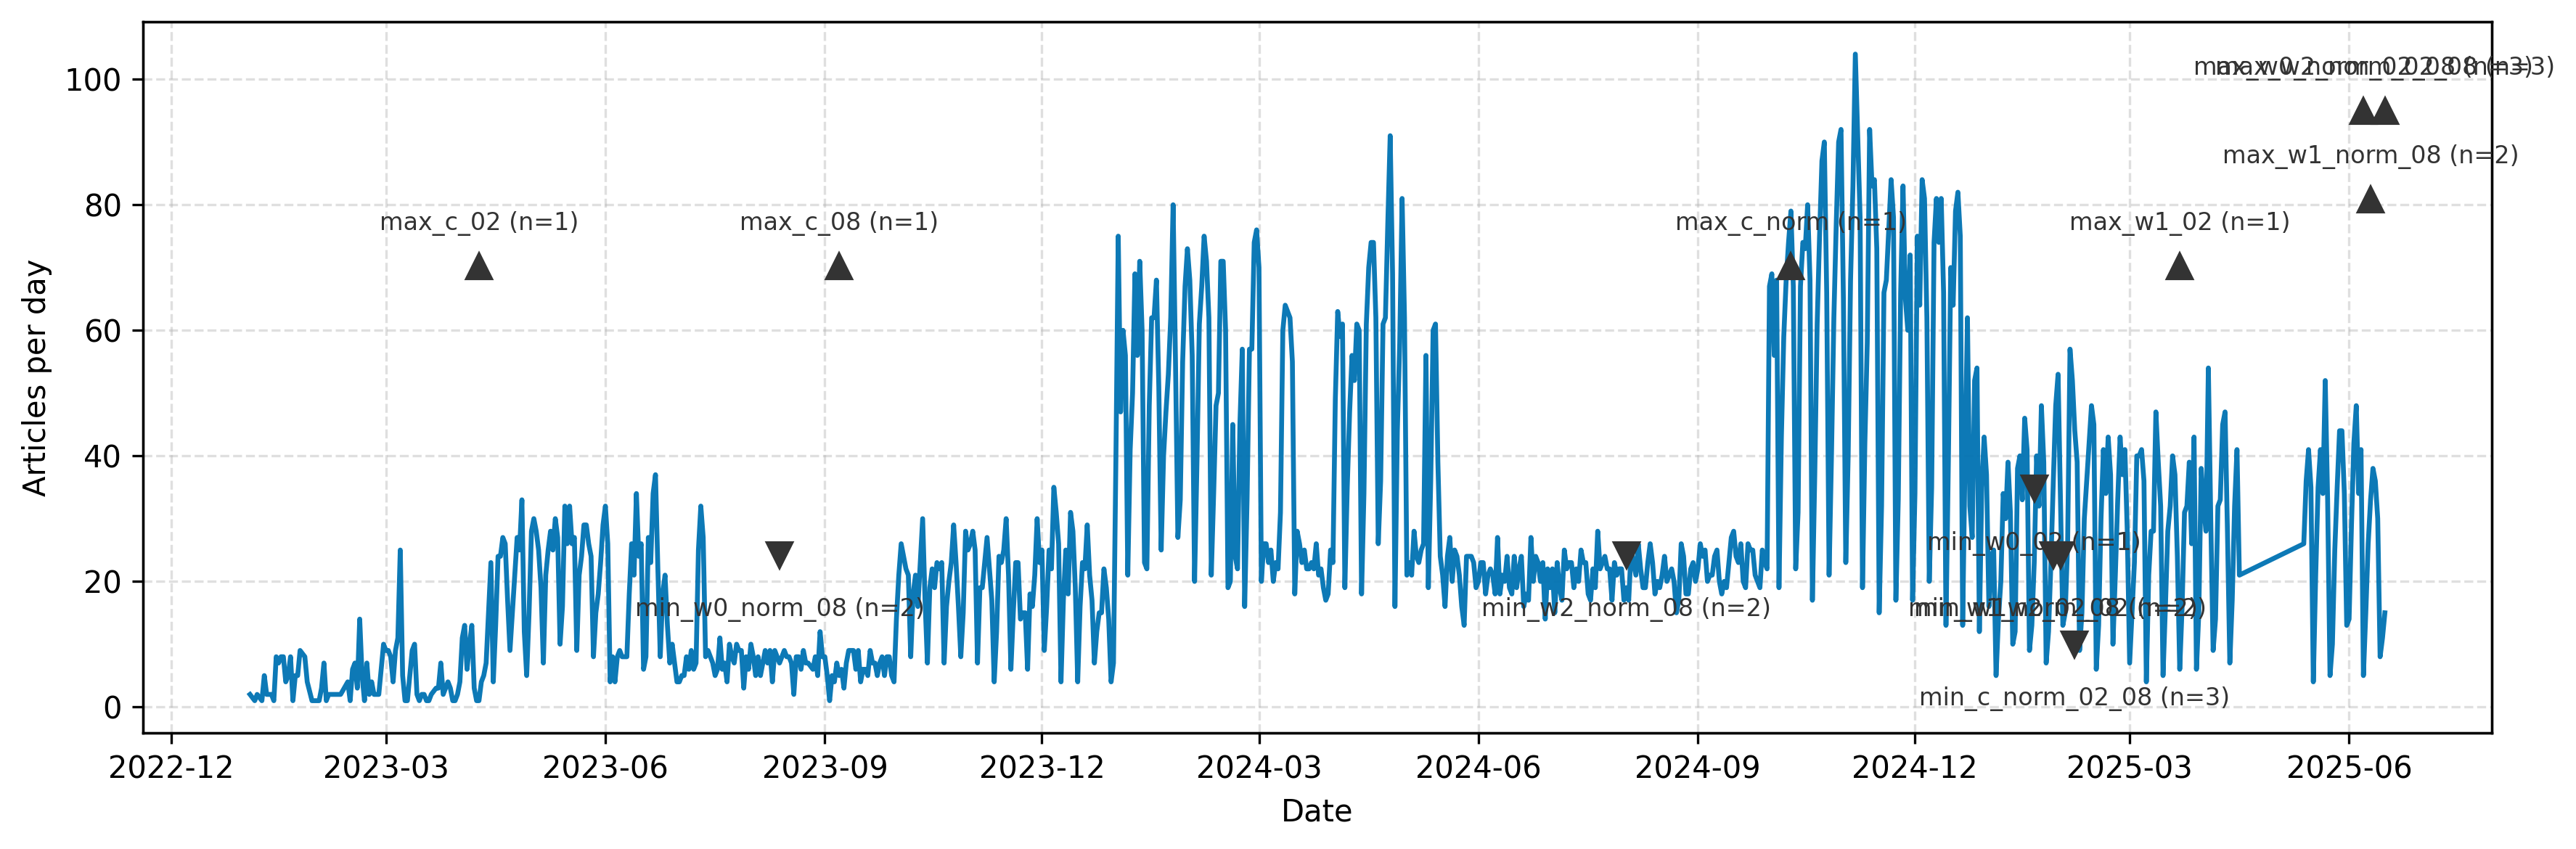

In [29]:
# plot timeline
fig, ax = plot_n_articles_with_extrema_events(
    dfp=dfp, date_col=None, count_col="n_articles",
    outpath="reports/figures/n_articles_with_extrema.png", annotate=True
)

In [30]:
# save extrema for reporting
extrema.sort_values(["type","n measures"],ascending=(False,False)).to_csv(var_path/ "extrema.csv")

Ensure article count does not bias AINI

Manually investiagte Minima & Maxima

In [31]:
# drop noisy estimates
#merged_clean = merged[merged["date"] != min_1]

# ensure datetime type
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")

# subsets per year
df_2023 = complete_df[complete_df["date"].dt.year == 2023]
df_2024 = complete_df[complete_df["date"].dt.year == 2024]
df_2025 = complete_df[complete_df["date"].dt.year == 2025]


Investigate AINI by year

Compare measures across each other

Manually investigate atricles on extrema-dates

Saved: C:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\extrema_timeline.png


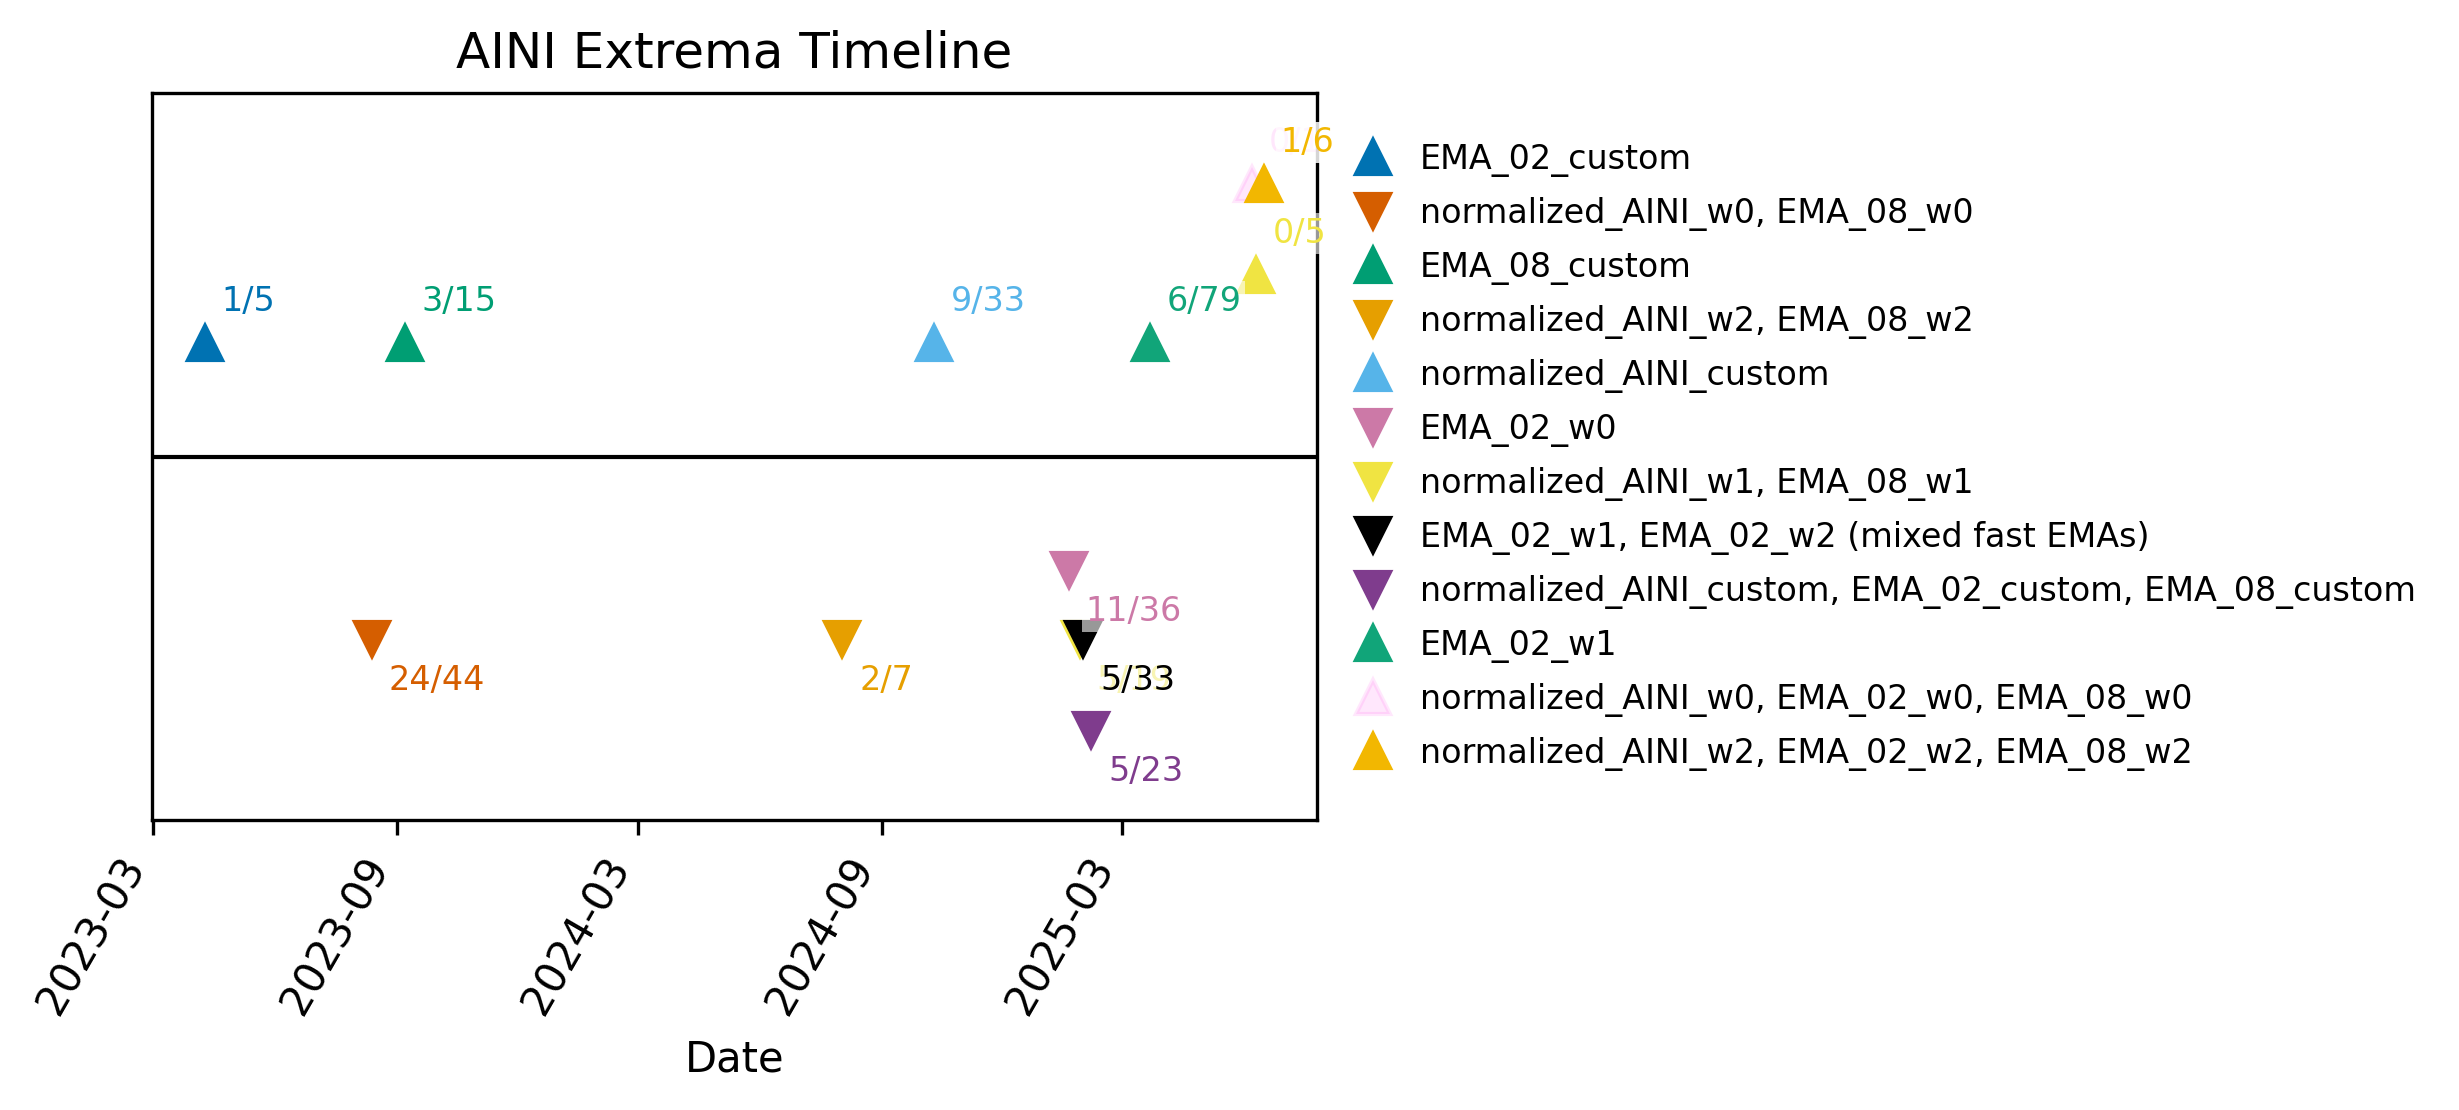

In [32]:
# investigate distribution via timeline
outpath = fig_path / "extrema_timeline.png"
fig, ax = plot_timeline(
    fractions_min=["24/44", "2/7", "11/36", "5/19", "5/33", "5/23"],
    fractions_max=["1/5", "3/15", "9/33", "6/79", "0/1", "0/5", "1/6"],
    outpath="reports/figures/aini_timeline_with_fractions.png"
)

print(f"Saved: {outpath.resolve()}")

In [33]:
# unpack subsets into individual dfs

# maxima
art_max_1_w0     = subsets["art_max_1_w0"]      # cutoff: 2025-06-07 | n=3 normalized_AINI_w0, EMA_02_w0, EMA_08_w0
art_max_1_w2     = subsets["art_max_1_w2"]      # cutoff: 2025-06-16 | n=3 normalized_AINI_w2, EMA_02_w2, EMA_08_w2
art_max_2_w1     = subsets["art_max_2_w1"]      # cutoff: 2025-06-10 | n=2 normalized_AINI_w1, EMA_08_w1
art_max_3_c_norm = subsets["art_max_3_c_norm"]  # cutoff: 2024-10-10 | n=1 normalized_AINI_custom
art_max_3_c_02   = subsets["art_max_3_c_02"]    # cutoff: 2023-04-09 | n=1 EMA_02_custom
art_max_3_c_08   = subsets["art_max_3_c_08"]    # cutoff: 2023-09-07 | n=1 EMA_08_custom
art_max_3_w1_02  = subsets["art_max_3_w1_02"]   # cutoff: 2025-03-22 | n=1 EMA_02_w1

# minima
art_min_1_custom = subsets["art_min_1_custom"]  # cutoff: 2025-02-06 | n=3 normalized_AINI_custom, EMA_02_custom, EMA_08_custom
art_min_2_w0     = subsets["art_min_2_w0"]      # cutoff: 2023-08-13 | n=2 normalized_AINI_w0, EMA_08_w0
art_min_2_w1     = subsets["art_min_2_w1"]      # cutoff: 2025-01-28 | n=2 normalized_AINI_w1, EMA_08_w1
art_min_2_w2     = subsets["art_min_2_w2"]      # cutoff: 2024-08-02 | n=2 normalized_AINI_w2, EMA_08_w2
art_min_2_w1_w2  = subsets["art_min_2_w1_w2"]   # cutoff: 2025-01-31 | n=2 EMA_02_w1, EMA_02_w2 (mixed only)
art_min_3_w0_02  = subsets["art_min_3_w0_02"]   # cutoff: 2025-01-20 | n=1 EMA_02_w0



In [ ]:
# maxima according to window size = 0
read(art_max_1_w0)

Date       : 2025-06-07 00:00:00
Article ID : 20253907
Hype       : w0=1.000, w1=0.000, w2=0.000, c=-1.000
--------------------------------------------------------------------------------
[ai_window]
ai and crypto czar, has been privately encouraging.
--------------------------------------------------------------------------------
[ai_window_c]
photo : andrew leyden / zuma press behind the scenes, some people close to trump and musk have
sought to organize a phone call between the two men in an attempt to hash out their differences,
according to people familiar with the matter. david sacks, a venture capitalist who acts as trump ’
s ai and crypto czar, has been privately encouraging musk to call the president to try to mend the
relationship, according to people familiar with the matter. james fishback, a businessman and
supporter of both trump and musk, encouraged musk on social media to apologize to the president. a
spokeswoman for sacks declined to comment.
--------------------------

In [ ]:
# maxima according to window size = 2
read(art_max_1_w2)

Date       : 2025-06-16 00:00:00
Article ID : 20254115
Hype       : w0=1.000, w1=1.000, w2=1.000, c=0.000
--------------------------------------------------------------------------------
[ai_window]
gpus and. ai investments and a need for debt funding could pose risks,. ai infrastructure, as
spending is expected to grow 4 in compared with 65 in. ai event that it can meet surging demand for
artificial - intelligence hardware, showcasing upcoming product launches that aim to position the
company as a realistic alternative to. ai development, self - sufficiency, and global expansion,
among others.
--------------------------------------------------------------------------------
[ai_window_c]
shopify has historically grown its merchant base in times of significant disruption, including 2008,
the covid - 19 pandemic and brexit, showing the company ’ s growing role as a key strategic partner
for merchants, the analysts say. ( kelly. cloonan @ wsj. com ) 1415 et – piper sandler says advanced
m

In [ ]:
# maxima according normalized_AINI_w1, EMA_08_w1
read(art_max_2_w1)

Date       : 2025-06-10 00:00:00
Article ID : 20253954
Hype       : w0=0.000, w1=0.000, w2=1.000, c=-1.000
--------------------------------------------------------------------------------
[ai_window]
google extends employee buyout offers in push to raise ai spending u. s. employees across multiple
divisions offered chance to leave with severance. ai competitors. ai spending. the company has for
years been culling workers as it invests tens of billions of dollars to develop cutting - edge
artificial intelligence models and systems. ai competitors that threaten to erode its search
dominance. ai and other growth areas with the cost discipline needed to fund those activities. ai
race,. ai model and chatbot, known as. ai features to many of its products. u. s. introduction of "
ai.
--------------------------------------------------------------------------------
[ai_window_c]
title : google extends employee buyout offers in push to raise ai spending technology artificial
intelligence follow 

In [ ]:
# minima according to custom FinBERT
read(art_min_1_custom) # scraping issue

Date       : 2025-02-06 00:00:00
Article ID : 20251056
Hype       : w0=-1.000, w1=0.000, w2=1.000, c=-1.000
--------------------------------------------------------------------------------
[ai_window]
tech giants double down on their massive ai spending amazon,. meta pour billions into artificial
intelligence, undeterred by. ai.
--------------------------------------------------------------------------------
[ai_window_c]
title : tech giants double down on their massive ai spending technology artificial intelligence
follow tech giants double down on their massive ai spending amazon, google, microsoft and meta pour
billions into artificial intelligence, undeterred by deepseek ’ s rise save listen ( 2 min ) capital
spending, quarterly $ 75 billion meta 50 alphabet microsoft 25 amazon 0 2020 ’ 21 ’ 22 ’ 23 ’ 24
note : data in this chart and those below reflect purchases of property and equipment. this chart
shows data for each calendar quarter. microsoft ’ s fiscal year ends june 30. sour

In [45]:
# minima according to ["art_min_2_w1"]   # cutoff: 2025-01-28 | n=2 normalized_AINI_w1, EMA_08_w1
read(art_min_2_w1) 

Date       : 2025-01-28 00:00:00
Article ID : 2025720
Hype       : w0=-1.000, w1=-1.000, w2=-1.000, c=0.000
--------------------------------------------------------------------------------
[ai_window]
referring to the impact of artificial intelligence,. the new pope is making artificial intelligence
a signature issuebut. an. ai companion is just a phone call away for residents of this senior living
communityand their mental health is improving as a result. ai. ai, researchers argue that
fundamental flaws in reasoning models mean bots aren ' t on the verge of exceeding human smarts.
--------------------------------------------------------------------------------
[ai_window_c]
you ' ve run out of free articles. subscribe for unlimited access. subscribe now what to read next
technology amazon ceo says ai will lead to smaller workforce june 17, 2025 referring to the impact
of artificial intelligence, andy jassy tells employees, “ we expect that this will reduce our total
corporate workforc

Manual investigate unclear articles

In [46]:
# extract full corpus; investigated: 20253960; 20253982; 202415542; 20251095; 20251069; 2025720
corpus_text = w0_df.loc[w0_df["article_id"] == 2025720, "corpus"].iloc[0]
title = w0_df.loc[w0_df["article_id"] == 2025720, "title"].iloc[0]

print("TITLE:", title)
print("\nCORPUS:\n")
print(corpus_text)

TITLE: Sony Group Names COO Hiroki Totoki as New Chief Executive

CORPUS:

TECHNOLOGY
Sony Group Names COO Hiroki Totoki as New Chief Executive
Lin Tao will become the group’s new chief financial officer
By
Kosaku Narioka
Follow
Updated Jan. 28, 2025 10:01 pm ET
Save
Listen
(1 min)
PHOTO: JUSTIN SULLIVAN/GETTY IMAGES
Sony Group 6758 0.85%
increase; green up pointing triangle
said Chief Operating Officer Hiroki Totoki, who has led the company’s growth in entertainment content, would become chief executive on April 1.
The Japanese entertainment and electronics company said Wednesday that Lin Tao, who currently serves as senior vice president for finance at videogame unit Sony Interactive Entertainment, would become the group’s new chief financial officer.
You've run out of free articles.
Subscribe for unlimited access.
Subscribe Now
What to Read Next
TECHNOLOGY
Amazon CEO Says AI Will Lead to Smaller Workforce
June 17, 2025
Referring to the impact of artificial intelligence, Andy Jassy t